# Environment Setup

### Mounting Google Drive

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Dependencies

In [2]:
# Install dependencies
!pip install kaggle xgboost dagshub mlflow==2.22.0 -Uq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Dagshub / MLflow Setup

In [3]:
import dagshub
dagshub.init(repo_owner='Cimbir', repo_name='Store-Sales-Forecasting', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=7820cc88-e697-4976-8315-2e0c06b56ffa&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=2571c206b82625ac12d546c7ed50653dbafe9820bcc27673f969b752a221027c




Output()

Accessing as vvaza22

Initialized MLflow to track repo "Cimbir/Store-Sales-Forecasting"

Repository Cimbir/Store-Sales-Forecasting initialized!

### Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from abc import abstractmethod
from sklearn.metrics import mean_absolute_error
import mlflow

In [5]:
RANDOM_STATE = 42

### Download Dataset

In [6]:
FILEPATH = "/content/drive/MyDrive/ml/assignments/final"
COMPETITION = "walmart-recruiting-store-sales-forecasting"
DATA_PATH = "/content/data"

In [7]:
!mkdir -p ~/.kaggle
!cp {FILEPATH}/kaggle/kaggle.json ~/.kaggle/kaggle.json

In [8]:
!kaggle competitions download -c {COMPETITION}

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 610MB/s]


In [9]:
!mkdir -p {DATA_PATH}
!unzip -o {COMPETITION}.zip -d {DATA_PATH}

Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: /content/data/features.csv.zip  
  inflating: /content/data/sampleSubmission.csv.zip  
  inflating: /content/data/stores.csv  
  inflating: /content/data/test.csv.zip  
  inflating: /content/data/train.csv.zip  


In [10]:
!mkdir -p {DATA_PATH}/csv
!cp {DATA_PATH}/stores.csv {DATA_PATH}/csv/
!unzip -o {DATA_PATH}/train.csv.zip -d {DATA_PATH}/csv
!unzip -o {DATA_PATH}/features.csv.zip -d {DATA_PATH}/csv
!unzip -o {DATA_PATH}/test.csv.zip -d {DATA_PATH}/csv

Archive:  /content/data/train.csv.zip
  inflating: /content/data/csv/train.csv  
Archive:  /content/data/features.csv.zip
  inflating: /content/data/csv/features.csv  
Archive:  /content/data/test.csv.zip
  inflating: /content/data/csv/test.csv  


# Data Preparation

### Merge data to create DataFrame

In [11]:
train = pd.read_csv(f'{DATA_PATH}/csv/train.csv')
stores = pd.read_csv(f'{DATA_PATH}/csv/stores.csv')
features = pd.read_csv(f'{DATA_PATH}/csv/features.csv')

In [12]:
df = pd.merge(train, features, on=['Store', 'Date'], how='left')
df = pd.merge(df, stores, on='Store', how='left')
df = df.drop('IsHoliday_y', axis=1)
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [13]:
df.shape

(421570, 16)

### Visualize Average Weekly Sales in the Whole Dataset

In [14]:
df_holiday = df[df['IsHoliday_x'] == True].copy()
df_holiday.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
31,1,1,2010-09-10,18194.74,True,78.69,2.565,NaN,NaN,NaN,NaN,NaN,211.495190,7.787,A,151315
42,1,1,2010-11-26,18820.29,True,64.52,2.735,NaN,NaN,NaN,NaN,NaN,211.748433,7.838,A,151315
47,1,1,2010-12-31,19124.58,True,48.43,2.943,NaN,NaN,NaN,NaN,NaN,211.404932,7.838,A,151315
53,1,1,2011-02-11,37887.17,True,36.39,3.022,NaN,NaN,NaN,NaN,NaN,212.936705,7.742,A,151315


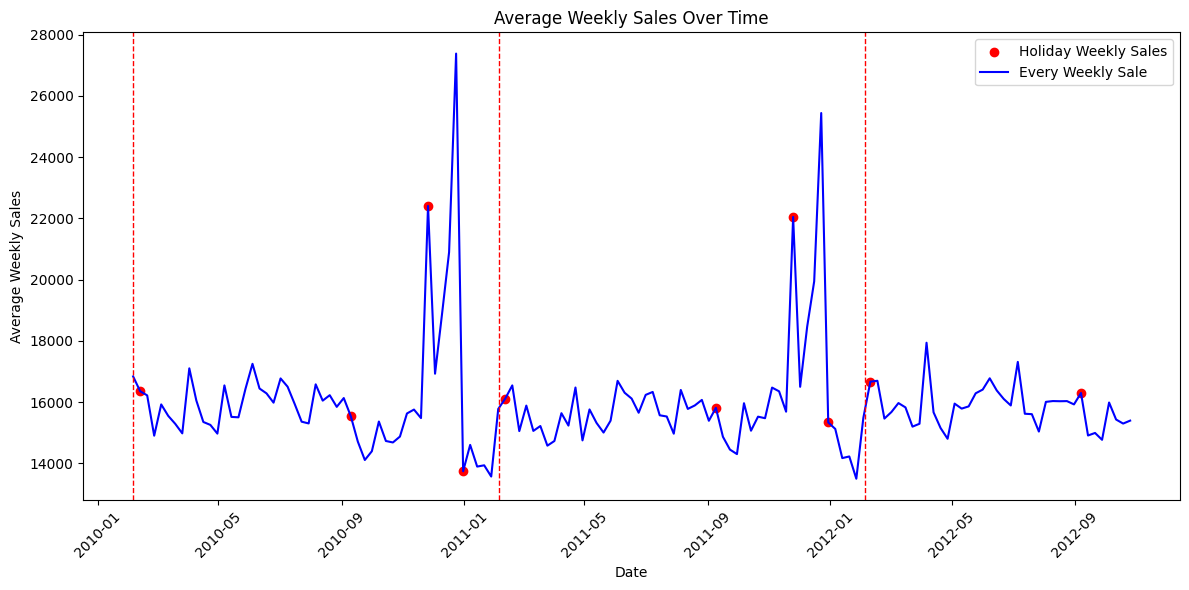

In [15]:
df['Date'] = pd.to_datetime(df['Date'])
df_holiday = df[df['IsHoliday_x'] == True].copy()

avg_sales_over_time = df.groupby('Date')['Weekly_Sales'].mean()
avg_sales_over_time_holiday = df_holiday.groupby('Date')['Weekly_Sales'].mean()

plt.figure(figsize=(12, 6))

plt.scatter(avg_sales_over_time_holiday.index, avg_sales_over_time_holiday.values, color='red', label='Holiday Weekly Sales')
plt.plot(avg_sales_over_time.index, avg_sales_over_time.values, color='blue', label='Every Weekly Sale')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales Over Time')
plt.xticks(rotation=45)
plt.tight_layout()

# Add vertical lines for the end of each year
years = pd.to_datetime(avg_sales_over_time.index).year.unique()
for year in years:
    end_of_year = pd.to_datetime(f'{year}-02-05')
    plt.axvline(end_of_year, color='red', linestyle='--', lw=1)

plt.show()

### Test/Train Dataset Split

In [16]:
SPLIT_DATE = '2011-09-01'

df['Date'] = pd.to_datetime(df['Date'])

# Train dataset
train = df[(df['Date'] < SPLIT_DATE)]

# Test dataset
test = df[(df['Date'] >= SPLIT_DATE)]
test.reset_index(drop=True, inplace=True)

In [17]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [18]:
train.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
421504,45,98,2011-07-29,599.03,False,81.31,3.829,NaN,NaN,NaN,NaN,NaN,186.295596,8.625,B,118221
421505,45,98,2011-08-05,982.60,False,78.22,3.842,NaN,NaN,NaN,NaN,NaN,186.373404,8.625,B,118221
421506,45,98,2011-08-12,827.40,False,77.00,3.812,NaN,NaN,NaN,NaN,NaN,186.451211,8.625,B,118221
421507,45,98,2011-08-19,535.68,False,72.98,3.747,NaN,NaN,NaN,NaN,NaN,186.509307,8.625,B,118221
421508,45,98,2011-08-26,385.96,False,72.55,3.704,NaN,NaN,NaN,NaN,NaN,186.564117,8.625,B,118221


In [19]:
test.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2011-09-02,15277.27,False,87.83,3.533,NaN,NaN,NaN,NaN,NaN,215.797141,7.962,A,151315
1,1,1,2011-09-09,17746.68,True,76.00,3.546,NaN,NaN,NaN,NaN,NaN,215.861056,7.962,A,151315
2,1,1,2011-09-16,18535.48,False,79.94,3.526,NaN,NaN,NaN,NaN,NaN,216.041053,7.962,A,151315
3,1,1,2011-09-23,17859.30,False,75.80,3.467,NaN,NaN,NaN,NaN,NaN,216.375825,7.962,A,151315
4,1,1,2011-09-30,18337.68,False,79.69,3.355,NaN,NaN,NaN,NaN,NaN,216.710597,7.962,A,151315


### Visualize Data Split

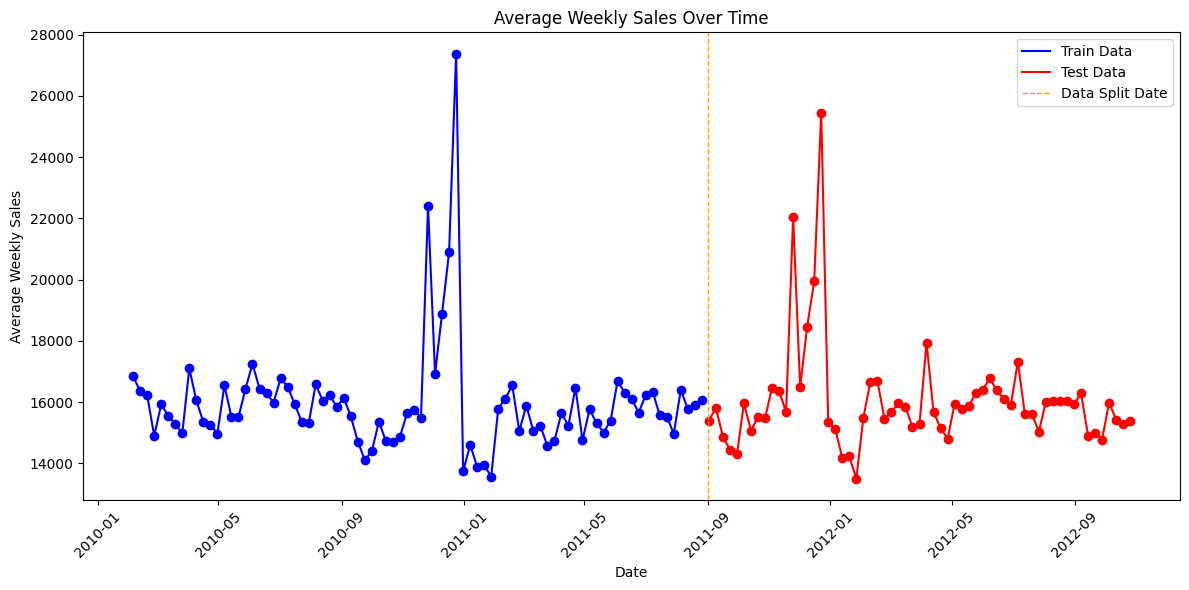

In [20]:
plt.figure(figsize=(12, 6))

# Plot train data
avg_train_sales = train.groupby('Date')['Weekly_Sales'].mean()
plt.scatter(avg_train_sales.index, avg_train_sales.values, color='blue')
plt.plot(avg_train_sales.index, avg_train_sales.values, color='blue', label='Train Data')

# Plot test data
avg_test_sales = test.groupby('Date')['Weekly_Sales'].mean()
plt.scatter(avg_test_sales.index, avg_test_sales.values, color='red')
plt.plot(avg_test_sales.index, avg_test_sales.values, color='red', label='Test Data')

# Add Split Line
plt.axvline(pd.to_datetime(SPLIT_DATE), color='orange', linestyle='--', lw=1, label='Data Split Date')

plt.xlabel('Date')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

### Prepare X_train, y_train

In [21]:
X_train = train.copy().sort_values(by=['Store', 'Dept', 'Date'])
y_train = X_train['Weekly_Sales']
X_train.drop('Weekly_Sales', axis=1, inplace=True)

In [22]:
X_train.head()

,Store,Dept,Date,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [23]:
y_train.head()

,Weekly_Sales
0,24924.50
1,46039.49
2,41595.55
3,19403.54
4,21827.90


### Prepare X_test, y_test

In [24]:
# Sort to get unique sequence
X_test = test.copy().sort_values(by=['Store', 'Dept', 'Date'])
y_test = X_test['Weekly_Sales']
X_test.drop('Weekly_Sales', axis=1, inplace=True)

In [25]:
test

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2011-09-02,15277.27,False,87.83,3.533,NaN,NaN,NaN,NaN,NaN,215.797141,7.962,A,151315
1,1,1,2011-09-09,17746.68,True,76.00,3.546,NaN,NaN,NaN,NaN,NaN,215.861056,7.962,A,151315
2,1,1,2011-09-16,18535.48,False,79.94,3.526,NaN,NaN,NaN,NaN,NaN,216.041053,7.962,A,151315
3,1,1,2011-09-23,17859.30,False,75.80,3.467,NaN,NaN,NaN,NaN,NaN,216.375825,7.962,A,151315
4,1,1,2011-09-30,18337.68,False,79.69,3.355,NaN,NaN,NaN,NaN,NaN,216.710597,7.962,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180962,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221
180963,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,B,118221
180964,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,B,118221
180965,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,B,118221


In [26]:
X_test.head()

,Store,Dept,Date,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2011-09-02,False,87.83,3.533,NaN,NaN,NaN,NaN,NaN,215.797141,7.962,A,151315
1,1,1,2011-09-09,True,76.00,3.546,NaN,NaN,NaN,NaN,NaN,215.861056,7.962,A,151315
2,1,1,2011-09-16,False,79.94,3.526,NaN,NaN,NaN,NaN,NaN,216.041053,7.962,A,151315
3,1,1,2011-09-23,False,75.80,3.467,NaN,NaN,NaN,NaN,NaN,216.375825,7.962,A,151315
4,1,1,2011-09-30,False,79.69,3.355,NaN,NaN,NaN,NaN,NaN,216.710597,7.962,A,151315


In [27]:
y_test.head()

,Weekly_Sales
0,15277.27
1,17746.68
2,18535.48
3,17859.30
4,18337.68


# Feature Engineering

### Pipeline Parts

In [28]:
class PrepareFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()

        # Split date into 3 separate features
        date_field = pd.to_datetime(X['Date'])
        X['Year'] = date_field.dt.year
        X['Month'] = date_field.dt.month
        X['Day'] = date_field.dt.day

        # Represent booleans as 1 and 0
        X['IsHoliday_x'] = X['IsHoliday_x'].astype(int)

        # Cast type into category to let xgboost handle it
        X['Type'] = X['Type'].astype('category')

        # Drop date field not to confuse xgboost
        X.drop('Date', axis=1, inplace=True)

        return X

In [30]:
class AddLags(BaseEstimator, TransformerMixin):
    def __init__(self, lags):
      self.lags = lags
      self.cache = {}

    def fit(self, X, y):
      X = X.copy()
      X['Date'] = pd.to_datetime(X['Date'])
      X['Weekly_Sales'] = y

      # For each (Store, Dept) cache lags for forecasting
      unique_store_dept = self.get_unique_store_dept(X)

      for store, dept in unique_store_dept:
        subset = X[(X['Store'] == store) & (X['Dept'] == dept)]
        subset = subset.sort_values(by='Date', ascending=True)

        self.cache[(store, dept)] = dict(zip(subset["Date"], subset["Weekly_Sales"]))

      # # Sample cache
      # print("Cache (1,1)", self.cache[(1,1)])

      return self

    def get_unique_store_dept(self, X):
      return X[['Store', 'Dept']].drop_duplicates().to_numpy()

    def get_cache(self, row, lag):
      dt = row['Date']
      store = row['Store']
      dept = row['Dept']

      c = self.cache[(store, dept)]
      key = dt - pd.DateOffset(days=lag)

      if not key in c:
        return np.nan

      return c[key]

    # Precondition X should contain Weekly_Sales
    def transform(self, X, y=None):
      X = X.copy()

      # Create lag features
      for lag in self.lags:
        X[f'Weekly_Sales_Lag_{lag}'] = X.apply(lambda row: self.get_cache(row, lag), axis=1)

      return X

In [31]:
subset11 = train[(train['Store'] == 1) & (train['Dept'] == 1)]
subset11 = subset11.sort_values(by='Date', ascending=True)
subset11.tail(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
77,1,1,2011-07-29,15922.41,False,86.83,3.682,NaN,NaN,NaN,NaN,NaN,215.483448,7.962,A,151315
78,1,1,2011-08-05,15295.55,False,91.65,3.684,NaN,NaN,NaN,NaN,NaN,215.544618,7.962,A,151315
79,1,1,2011-08-12,14539.79,False,90.76,3.638,NaN,NaN,NaN,NaN,NaN,215.605788,7.962,A,151315
80,1,1,2011-08-19,14689.24,False,89.94,3.554,NaN,NaN,NaN,NaN,NaN,215.669311,7.962,A,151315
81,1,1,2011-08-26,14537.37,False,87.96,3.523,NaN,NaN,NaN,NaN,NaN,215.733226,7.962,A,151315


In [360]:
lags_prep = AddLags(lags=[7,14])
lags_prep.fit(X_train, y_train)

lags_prep.cache[(1,1)]

{Timestamp('2010-02-05 00:00:00'): 24924.5,
 Timestamp('2010-02-12 00:00:00'): 46039.49,
 Timestamp('2010-02-19 00:00:00'): 41595.55,
 Timestamp('2010-02-26 00:00:00'): 19403.54,
 Timestamp('2010-03-05 00:00:00'): 21827.9,
 Timestamp('2010-03-12 00:00:00'): 21043.39,
 Timestamp('2010-03-19 00:00:00'): 22136.64,
 Timestamp('2010-03-26 00:00:00'): 26229.21,
 Timestamp('2010-04-02 00:00:00'): 57258.43,
 Timestamp('2010-04-09 00:00:00'): 42960.91,
 Timestamp('2010-04-16 00:00:00'): 17596.96,
 Timestamp('2010-04-23 00:00:00'): 16145.35,
 Timestamp('2010-04-30 00:00:00'): 16555.11,
 Timestamp('2010-05-07 00:00:00'): 17413.94,
 Timestamp('2010-05-14 00:00:00'): 18926.74,
 Timestamp('2010-05-21 00:00:00'): 14773.04,
 Timestamp('2010-05-28 00:00:00'): 15580.43,
 Timestamp('2010-06-04 00:00:00'): 17558.09,
 Timestamp('2010-06-11 00:00:00'): 16637.62,
 Timestamp('2010-06-18 00:00:00'): 16216.27,
 Timestamp('2010-06-25 00:00:00'): 16328.72,
 Timestamp('2010-07-02 00:00:00'): 16333.14,
 Timestamp('

In [362]:
X_train_with_lags = lags_prep.transform(X_train)
X_train_with_lags

,Store,Dept,Date,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Weekly_Sales_Lag_7,Weekly_Sales_Lag_14
0,1,1,2010-02-05,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,NaN,NaN
1,1,1,2010-02-12,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,24924.50,NaN
2,1,1,2010-02-19,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,46039.49,24924.50
3,1,1,2010-02-26,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,41595.55,46039.49
4,1,1,2010-03-05,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315,19403.54,41595.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421504,45,98,2011-07-29,False,81.31,3.829,NaN,NaN,NaN,NaN,NaN,186.295596,8.625,B,118221,614.73,1033.14
421505,45,98,2011-08-05,False,78.22,3.842,NaN,NaN,NaN,NaN,NaN,186.373404,8.625,B,118221,599.03,614.73
421506,45,98,2011-08-12,False,77.00,3.812,NaN,NaN,NaN,NaN,NaN,186.451211,8.625,B,118221,982.60,599.03
421507,45,98,2011-08-19,False,72.98,3.747,NaN,NaN,NaN,NaN,NaN,186.509307,8.625,B,118221,827.40,982.60


In [269]:
unique_store_dept = X_train[['Store', 'Dept']].drop_duplicates()
unique_store_dept.to_numpy()

array([[ 1,  1],
       [ 1,  2],
       [ 1,  3],
       ...,
       [45, 95],
       [45, 97],
       [45, 98]])

In [277]:
subset = train[(train['Store'] == 1) & (train['Dept'] == 1)]
subset = subset.sort_values(by='Date')
subset

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1,1,2011-07-29,15922.41,False,86.83,3.682,NaN,NaN,NaN,NaN,NaN,215.483448,7.962,A,151315
78,1,1,2011-08-05,15295.55,False,91.65,3.684,NaN,NaN,NaN,NaN,NaN,215.544618,7.962,A,151315
79,1,1,2011-08-12,14539.79,False,90.76,3.638,NaN,NaN,NaN,NaN,NaN,215.605788,7.962,A,151315
80,1,1,2011-08-19,14689.24,False,89.94,3.554,NaN,NaN,NaN,NaN,NaN,215.669311,7.962,A,151315


In [278]:
subset.shift(1)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
1,1.0,1.0,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315.0
2,1.0,1.0,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315.0
3,1.0,1.0,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315.0
4,1.0,1.0,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1.0,1.0,2011-07-22,15766.60,False,85.77,3.651,NaN,NaN,NaN,NaN,NaN,215.422278,7.962,A,151315.0
78,1.0,1.0,2011-07-29,15922.41,False,86.83,3.682,NaN,NaN,NaN,NaN,NaN,215.483448,7.962,A,151315.0
79,1.0,1.0,2011-08-05,15295.55,False,91.65,3.684,NaN,NaN,NaN,NaN,NaN,215.544618,7.962,A,151315.0
80,1.0,1.0,2011-08-12,14539.79,False,90.76,3.638,NaN,NaN,NaN,NaN,NaN,215.605788,7.962,A,151315.0


In [279]:
subset

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1,1,2011-07-29,15922.41,False,86.83,3.682,NaN,NaN,NaN,NaN,NaN,215.483448,7.962,A,151315
78,1,1,2011-08-05,15295.55,False,91.65,3.684,NaN,NaN,NaN,NaN,NaN,215.544618,7.962,A,151315
79,1,1,2011-08-12,14539.79,False,90.76,3.638,NaN,NaN,NaN,NaN,NaN,215.605788,7.962,A,151315
80,1,1,2011-08-19,14689.24,False,89.94,3.554,NaN,NaN,NaN,NaN,NaN,215.669311,7.962,A,151315


## Preprocessor pipelines

### Preprocessor 1

In [29]:
def preprocessor_factory1():
  return Pipeline([
      ('prepare_features', PrepareFeatures()),
  ])

In [ ]:
mlflow.set_experiment("XGBoost_Training")
mlflow.set_tracking_uri("https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow")

with mlflow.start_run(run_name="XGBoost_Preprocessor_1"):
    mlflow.log_params({
        "pipeline": ["prepare_features"]
    })
    mlflow.sklearn.log_model(preprocessor_factory1(), "XGBoost_Preprocessor", input_example=X_train.head())

### Preprocessor 2

In [320]:
def preprocessor_factory2(lags):
  return Pipeline([
      ('add_lags', AddLags(lags)),
      ('prepare_features', PrepareFeatures()),
  ])

In [317]:
train

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421504,45,98,2011-07-29,599.03,False,81.31,3.829,NaN,NaN,NaN,NaN,NaN,186.295596,8.625,B,118221
421505,45,98,2011-08-05,982.60,False,78.22,3.842,NaN,NaN,NaN,NaN,NaN,186.373404,8.625,B,118221
421506,45,98,2011-08-12,827.40,False,77.00,3.812,NaN,NaN,NaN,NaN,NaN,186.451211,8.625,B,118221
421507,45,98,2011-08-19,535.68,False,72.98,3.747,NaN,NaN,NaN,NaN,NaN,186.509307,8.625,B,118221


In [323]:
lags1 = preprocessor_factory2(lags=1)
train_processed = lags1.fit_transform(train)

In [324]:
train_processed

,Store,Dept,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Weekly_Sales_Lag_1,Year,Month,Day
0,1,1,24924.50,0,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,NaN,2010,2,5
1,1,1,46039.49,1,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,24924.50,2010,2,12
2,1,1,41595.55,0,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,46039.49,2010,2,19
3,1,1,19403.54,0,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,41595.55,2010,2,26
4,1,1,21827.90,0,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315,19403.54,2010,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240598,45,98,599.03,0,81.31,3.829,NaN,NaN,NaN,NaN,NaN,186.295596,8.625,B,118221,614.73,2011,7,29
240599,45,98,982.60,0,78.22,3.842,NaN,NaN,NaN,NaN,NaN,186.373404,8.625,B,118221,599.03,2011,8,5
240600,45,98,827.40,0,77.00,3.812,NaN,NaN,NaN,NaN,NaN,186.451211,8.625,B,118221,982.60,2011,8,12
240601,45,98,535.68,0,72.98,3.747,NaN,NaN,NaN,NaN,NaN,186.509307,8.625,B,118221,827.40,2011,8,19


In [326]:
mlflow.set_experiment("XGBoost_Training")
mlflow.set_tracking_uri("https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow")

with mlflow.start_run(run_name="XGBoost_Preprocessor_2_Lags_1"):
    mlflow.log_params({
        "pipeline": ["add_lags", "prepare_features"]
    })
    mlflow.sklearn.log_model(preprocessor_factory2(lags=1), "XGBoost_Preprocessor")

2025/07/04 22:24:56 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/07/04 22:25:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Preprocessor_2_Lags_1 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/df02e6f9d66b413dbc15a9fc635a3e53
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


# Model Pipeline

## Evaluation functions

In [30]:
def WMAE(dataset, real, predict):
  weights = dataset['IsHoliday_x'].apply(lambda x: 5 if x else 1)
  return (np.sum(weights * abs(real - predict)) / np.sum(weights))

In [31]:
# Custom Eval metric WMAE
def wmae_eval(preds, dtrain):
    y_true = dtrain.get_label()
    weights = dtrain.get_weight()
    return 'wmae', np.sum(weights * abs(y_true - preds)) / np.sum(weights)

In [32]:
def plot_predictions(train, test, pred):
  plt.figure(figsize=(12, 6))

  avg_sales_over_time = train.groupby('Date')['Weekly_Sales'].mean()
  plt.plot(avg_sales_over_time.index, avg_sales_over_time.values, color='blue', label='Train')

  avg_sales_over_time = test.groupby('Date')['Weekly_Sales'].mean()
  plt.plot(avg_sales_over_time.index, avg_sales_over_time.values, color='red', label='Validation')

  avg_sales_over_time = pred.groupby('Date')['Weekly_Sales'].mean()
  plt.plot(avg_sales_over_time.index, avg_sales_over_time.values, color='purple', label='Prediction')

  plt.legend()
  plt.xlabel('Date')
  plt.ylabel('Average Weekly Sales')
  plt.title('Average Weekly Sales Over Time')
  plt.xticks(rotation=45)
  plt.tight_layout()

  # Save plot to upload later to mlflow
  plt.savefig("prediction.png")

  plt.show()

In [33]:
def log_experiment(model, mlflow_log=True):
  params = model.train_params
  print("Model Training Params", params)

  metrics = model.get_metrics(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
  print("Model Metrics", metrics)

  data = model.model_data()
  print("Model Data", data)

  plot_predictions(train, test, model.get_prediction_table(X_test))

  if mlflow_log:
    log_experiment_in_mlflow(model, params, metrics, data)

def log_experiment_in_mlflow(model, params, metrics, data):
  mlflow.set_experiment("XGBoost_Training")
  mlflow.set_tracking_uri("https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow")

  with mlflow.start_run(run_name=data["run_name"]):
      mlflow.log_params(params)
      mlflow.log_metrics(metrics)
      mlflow.xgboost.log_model(model.model, "XGBoost Model")

      # Artifacts
      for artifact in data["artifacts"]:
        mlflow.log_artifact(artifact)

In [74]:
def plot_store_dept(model, store, dept):
  train_view = train[(train['Store'] == store) & (train['Dept'] == dept)]
  test_view = test[(test['Store'] == store) & (test['Dept'] == dept)]
  X_test_view = X_test[(X_test['Store'] == store) & (X_test['Dept'] == dept)]
  X_train_view = X_train[(X_train['Store'] == store) & (X_train['Dept'] == dept)]

  plot_predictions_store_dept(
      train=train_view,
      test=test_view,
      pred=model.get_prediction_table(X_test_view),
      pred_train=model.get_prediction_table(X_train_view),
      store=store,
      dept=dept)

In [73]:
def plot_predictions_store_dept(train, test, pred, pred_train, store, dept):
  plt.figure(figsize=(12, 6))

  avg_sales_over_time = train.groupby('Date')['Weekly_Sales'].mean()
  plt.plot(avg_sales_over_time.index, avg_sales_over_time.values, color='blue', label='Train')

  avg_sales_over_time = test.groupby('Date')['Weekly_Sales'].mean()
  plt.plot(avg_sales_over_time.index, avg_sales_over_time.values, color='red', label='Validation')

  avg_sales_over_time = pred_train.groupby('Date')['Weekly_Sales'].mean()
  plt.plot(avg_sales_over_time.index, avg_sales_over_time.values, color='orange', label='Train Prediction')

  avg_sales_over_time = pred.groupby('Date')['Weekly_Sales'].mean()
  plt.plot(avg_sales_over_time.index, avg_sales_over_time.values, color='purple', label='Prediction')

  plt.legend()
  plt.xlabel('Date')
  plt.ylabel('Weekly Sales')
  plt.title(f'Weekly Sales for ({store}, {dept})')
  plt.xticks(rotation=45)
  plt.tight_layout()

  # Save plot to upload later to mlflow
  # plt.savefig("prediction.png")

  plt.show()

In [70]:
class BaseModel:
  def __init__(self, preprocessor_factory):
    self.train_params = self.init_train_params()
    self.preprocessor_factory = preprocessor_factory
    self.preprocessor = None
    self.model = None

  @abstractmethod
  def model_data(self):
    pass

  @abstractmethod
  def init_train_params(self):
    pass

  def train(self, X_train, y_train, X_test, y_test):
    self.preprocessor = self.preprocessor_factory()
    self.preprocessor = self.preprocessor.fit(X_train)

    # Preprocess X_train and X_test
    X_train_processed = self.preprocessor.transform(X_train)
    X_test_processed = self.preprocessor.transform(X_test)

    # Convert to xgboost matrices
    dtrain = xgb.DMatrix(X_train_processed, label=y_train, enable_categorical=True)
    dtest = xgb.DMatrix(X_test_processed, label=y_test, enable_categorical=True)

    # Calculate weights for each data point for WMAE metric
    weights_train = X_train_processed['IsHoliday_x'].apply(lambda x: 5 if x else 1).to_numpy()
    weights_test = X_test_processed['IsHoliday_x'].apply(lambda x: 5 if x else 1).to_numpy()

    dtrain.set_info(weight=weights_train)
    dtest.set_info(weight=weights_test)

    print("Using Training Params", self.train_params)

    self.model = xgb.train(
        **self.train_params,
        custom_metric=wmae_eval,
        dtrain=dtrain,
        evals=[(dtrain, 'train'), (dtest, 'test')],
        verbose_eval=True,
    )

    return self

  def predict(self, X):
    X_processed = self.preprocessor.transform(X)
    X_matrix = xgb.DMatrix(X_processed, enable_categorical=True)

    y_pred = self.model.predict(X_matrix)

    return y_pred

  def get_prediction_table(self, X_test):
    y_pred = self.predict(X_test)
    pred = X_test.copy()
    pred['Weekly_Sales'] = y_pred
    return pred

  def get_metrics(self, X_train, y_train, X_test, y_test):

    pred_train = self.predict(X_train)
    pred_test = self.predict(X_test)
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    result = {
        "mae_train": mean_absolute_error(y_train, pred_train),
        "mae_test": mean_absolute_error(y_test, pred_test),
        "wmae_train": WMAE(X_train, y_train, pred_train),
        "wmae_test": WMAE(X_test, y_test, pred_test),
    }

    return result

In [71]:
# class CustomXGB(mlflow.pyfunc.PythonModel):
#   def __init__(self):
#       self.model = model

#   def load_context(self, context):
#       pass

#   def train(self, X_train, y_train, X_test, y_test):


#   def predict(self, context, model_input, params=None):
#     # Preprocess data
#     lags = AddLags(lags=[7, 14, 21])
#     lags.fit(X_train, y_train)
#     X_test_processed = lags.transform(model_input)
import copy

class CustomXGB(mlflow.pyfunc.PythonModel):
  def __init__(self):
    self.train_params = self.init_train_params()
    self.model = None

  @abstractmethod
  def model_data(self):
    pass

  @abstractmethod
  def init_train_params(self):
    pass

  def prep_fit_transform(self, X_train, y_train):
    self.prep_lags = AddLags(lags=[7, 14, 21])
    self.prep_lags.fit(X_train, y_train)

    X_train_1 = self.prep_lags.transform(X_train)

    self.prep_feats = PrepareFeatures()
    self.prep_feats.fit(X_train_1, y_train)

    X_train_2 = self.prep_feats.transform(X_train_1)

    return X_train_2

  def load_context(self, context):
    pass

  def prep_transform(self, X):
    X_1 = self.prep_lags.transform(X)
    X_2 = self.prep_feats.transform(X_1)

    return X_2

  def train(self, X_train, y_train):
    # Fit preprocessor
    X_train_processed = self.prep_fit_transform(X_train, y_train)

    # Convert to xgboost matrices
    dtrain = xgb.DMatrix(X_train_processed, label=y_train, enable_categorical=True)

    # Calculate weights for each data point for WMAE metric
    weights_train = X_train_processed['IsHoliday_x'].apply(lambda x: 5 if x else 1).to_numpy()

    dtrain.set_info(weight=weights_train)

    print("Using Training Params", self.train_params)

    self.model = xgb.train(
        **self.train_params,
        dtrain=dtrain,
    )

    return self

  def predict(self, context, model_input, params=None):
    cache = copy.deepcopy(self.prep_lags.cache)
    X = model_input.sort_values(by=['Store', 'Dept', 'Date'])

    # Preprocess data
    X_processed = self.prep_transform(X)
    X_processed.reset_index(drop=True, inplace=True)

    #print(X_processed)

    results = np.zeros(len(X_processed))

    for i in range(len(X_processed)):
      row = X_processed.iloc[i:i+1]

      # #print(row
      store = X_processed['Store'].iloc[i]
      dept = X_processed['Dept'].iloc[i]
      year = X_processed['Year'].iloc[i]
      month = X_processed['Month'].iloc[i]
      day = X_processed['Day'].iloc[i]

      # #print(store, dept, year, month, day)
      date = pd.to_datetime(f"{year}-{month}-{day}")

      # Fill NA values
      for lag in [7, 14, 21]:
        lag_feat = f'Weekly_Sales_Lag_{lag}'
        key = date - pd.DateOffset(days=lag)

        if key in cache[(store, dept)]:
          row.at[i, lag_feat] = cache[(store, dept)][key]


      #print(row)

      # row = pd.DataFrame(row)
      # print(row.dtypes)
      # print(row)
      # break
      # Predict for single row
      X_matrix = xgb.DMatrix(row, enable_categorical=True)
      y_pred = self.model.predict(X_matrix)


      cache[(store, dept)][date] = y_pred[0]

      results[i] = y_pred[0]

    # X_processed = self.prep_transform(model_input)
    # X_matrix = xgb.DMatrix(X_processed, enable_categorical=True)

    # y_pred = self.model.predict(X_matrix)

    return results

  def get_prediction_table(self, X_test):
    y_pred = self.predict(X_test)
    pred = X_test.copy()
    pred['Weekly_Sales'] = y_pred
    return pred

  def get_metrics(self, X_train, y_train, X_test, y_test):

    pred_train = self.predict(None, X_train)
    pred_test = self.predict(None, X_test)
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    result = {
        "mae_train": mean_absolute_error(y_train, pred_train),
        "mae_test": mean_absolute_error(y_test, pred_test),
        "wmae_train": WMAE(X_train, y_train, pred_train),
        "wmae_test": WMAE(X_test, y_test, pred_test),
    }

    return result

/usr/local/lib/python3.11/dist-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [164]:
class ModelTest(CustomXGB):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_SquaredError_Estimator_1",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
      },
      'num_boost_round': 30,
    }

In [170]:
model_test = ModelTest()
model_test.train(X_train, y_train)

Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae'}, 'num_boost_round': 30}


In [175]:
pred = model_test.predict(None, X_test.head(10))

In [176]:
pred

array([15331.00585938, 18047.93164062, 18947.26171875, 20247.5390625 ,
       21629.4375    , 24516.65429688, 29081.9765625 , 32177.45117188,
       36787.4609375 , 34020.1484375 ])

In [177]:
y_test.head(10)

,Weekly_Sales
0,15277.27
1,17746.68
2,18535.48
3,17859.30
4,18337.68
5,20797.58
6,23077.55
7,23351.80
8,31579.90
9,39886.06


In [169]:
model_test.get_metrics(X_train.head(30), y_train.head(30), X_train.iloc[30:50], y_train.iloc[30:50])

{'mae_train': 1637.5168554687502,
 'mae_test': 7645.154148437499,
 'wmae_train': np.float64(4097.618475413602),
 'wmae_test': np.float64(5361.013188476563)}

In [153]:
tb = X_train.iloc[25:31]
tb

,Store,Dept,Date,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
25,1,1,2010-07-30,False,81.84,2.640,NaN,NaN,NaN,NaN,NaN,211.369903,7.787,A,151315
26,1,1,2010-08-06,False,87.16,2.627,NaN,NaN,NaN,NaN,NaN,211.504662,7.787,A,151315
27,1,1,2010-08-13,False,87.00,2.692,NaN,NaN,NaN,NaN,NaN,211.639421,7.787,A,151315
28,1,1,2010-08-20,False,86.65,2.664,NaN,NaN,NaN,NaN,NaN,211.603363,7.787,A,151315
29,1,1,2010-08-27,False,85.22,2.619,NaN,NaN,NaN,NaN,NaN,211.567306,7.787,A,151315
30,1,1,2010-09-03,False,81.21,2.577,NaN,NaN,NaN,NaN,NaN,211.531248,7.787,A,151315


In [158]:
y_train.iloc[25:36]

,Weekly_Sales
25,15381.82
26,17508.41
27,15536.40
28,15740.13
29,15793.87
30,16241.78
31,18194.74
32,19354.23
33,18122.52
34,20094.19


In [107]:
tb['Date'].iloc[0]

Timestamp('2010-09-03 00:00:00')

# Experiments

## Experiment 1:

In [ ]:
def custom_mae(y_pred, dtrain):
    y_true = dtrain.get_label()
    grad = np.sign(y_pred - y_true)
    hess = np.zeros_like(y_true)
    return grad, hess

class Model1(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_SquaredError_Estimator_1",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
      },
      'num_boost_round': 1,
    }

In [ ]:
model1 = Model1(preprocessor_factory=preprocessor_factory1)
model1.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae'}, 'num_boost_round': 1}
[0]	train-mae:12099.41442	train-wmae:12099.41406	test-mae:12441.13561	test-wmae:12441.13477


In [ ]:
model1.get_metrics(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


{'mae_train': 11973.169828915361,
 'mae_test': 12228.32872152796,
 'wmae_train': np.float64(12099.414434121085),
 'wmae_test': np.float64(12441.135631336625)}

Model Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae'}, 'num_boost_round': 1}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 11973.169828915361, 'mae_test': 12228.32872152796, 'wmae_train': np.float64(12099.414434121085), 'wmae_test': np.float64(12441.135631336625)}
Model Data {'run_name': 'XGBoost_Obj_SquaredError_Estimator_1', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


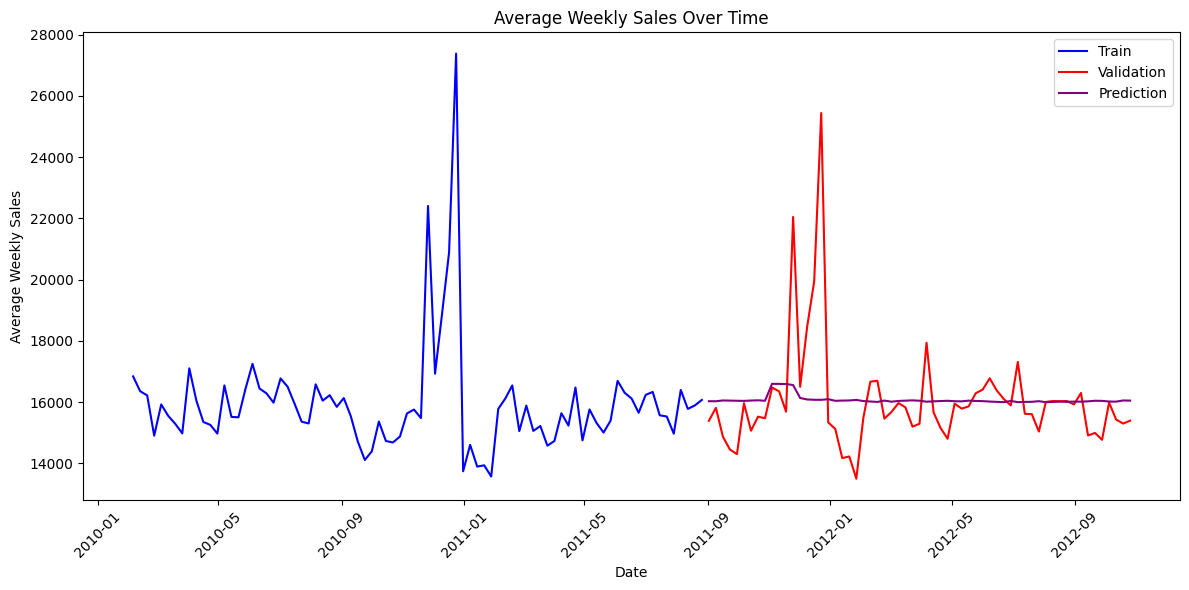

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [18:21:11] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/04 18:21:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_SquaredError_Estimator_1 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/d29087623d09491db75fdcc53adf4d80
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
log_experiment(model1)

## Experiment 2

In [ ]:
class Model2(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_SquaredError_Estimator_10",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
      },
      'num_boost_round': 10,
    }

In [ ]:
model2 = Model2(preprocessor_factory=preprocessor_factory1)
model2.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae'}, 'num_boost_round': 10}
[0]	train-mae:12099.41442	train-wmae:12099.41406	test-mae:12441.13561	test-wmae:12441.13477
[1]	train-mae:10088.84035	train-wmae:10088.83691	test-mae:10427.93009	test-wmae:10427.93066
[2]	train-mae:9039.72091	train-wmae:9039.72070	test-mae:9361.19315	test-wmae:9361.19238
[3]	train-mae:8291.39645	train-wmae:8291.39648	test-mae:8605.41074	test-wmae:8605.41016
[4]	train-mae:7592.52638	train-wmae:7592.52686	test-mae:7868.85911	test-wmae:7868.85938
[5]	train-mae:7033.36069	train-wmae:7033.36035	test-mae:7297.26162	test-wmae:7297.26172
[6]	train-mae:6697.45105	train-wmae:6697.45117	test-mae:6955.95090	test-wmae:6955.95020
[7]	train-mae:6305.78547	train-wmae:6305.78467	test-mae:6586.02921	test-wmae:6586.02930
[8]	train-mae:6060.30066	train-wmae:6060.30029	test-mae:6351.16099	test-wmae:6351.16260
[9]	train-mae:5879.55288	train-wmae:5879.55273	test-mae:6212.39136	test-wmae:6212.39062

Model Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae'}, 'num_boost_round': 10}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 5764.782735066285, 'mae_test': 6036.0493256207, 'wmae_train': np.float64(5879.552881854245), 'wmae_test': np.float64(6212.391364160469)}
Model Data {'run_name': 'XGBoost_Obj_SquaredError_Estimator_10', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


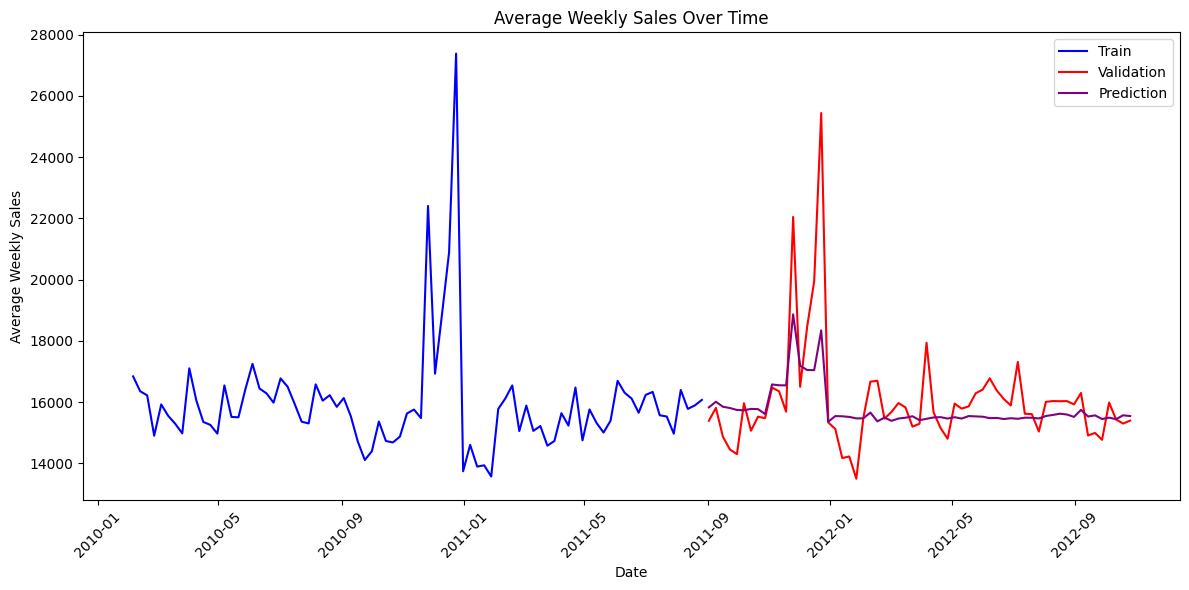

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [18:24:10] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/04 18:24:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_SquaredError_Estimator_10 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/ba79638ed44f47378550e16da9c20bc6
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
log_experiment(model2)

## Experiment 3

In [ ]:
class Model3(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_SquaredError_Estimator_50",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
      },
      'num_boost_round': 50,
    }

In [ ]:
model3 = Model3(preprocessor_factory=preprocessor_factory1)
model3.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae'}, 'num_boost_round': 50}
[0]	train-mae:12099.41442	train-wmae:12099.41406	test-mae:12441.13561	test-wmae:12441.13477
[1]	train-mae:10088.84035	train-wmae:10088.83691	test-mae:10427.93009	test-wmae:10427.93066
[2]	train-mae:9039.72091	train-wmae:9039.72070	test-mae:9361.19315	test-wmae:9361.19238
[3]	train-mae:8291.39645	train-wmae:8291.39648	test-mae:8605.41074	test-wmae:8605.41016
[4]	train-mae:7592.52638	train-wmae:7592.52686	test-mae:7868.85911	test-wmae:7868.85938
[5]	train-mae:7033.36069	train-wmae:7033.36035	test-mae:7297.26162	test-wmae:7297.26172
[6]	train-mae:6697.45105	train-wmae:6697.45117	test-mae:6955.95090	test-wmae:6955.95020
[7]	train-mae:6305.78547	train-wmae:6305.78467	test-mae:6586.02921	test-wmae:6586.02930
[8]	train-mae:6060.30066	train-wmae:6060.30029	test-mae:6351.16099	test-wmae:6351.16260
[9]	train-mae:5879.55288	train-wmae:5879.55273	test-mae:6212.39136	test-wmae:6212.39062

Model Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae'}, 'num_boost_round': 50}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 3459.664740232108, 'mae_test': 3965.1957558024737, 'wmae_train': np.float64(3543.304080702551), 'wmae_test': np.float64(4149.590688103082)}
Model Data {'run_name': 'XGBoost_Obj_SquaredError_Estimator_50', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


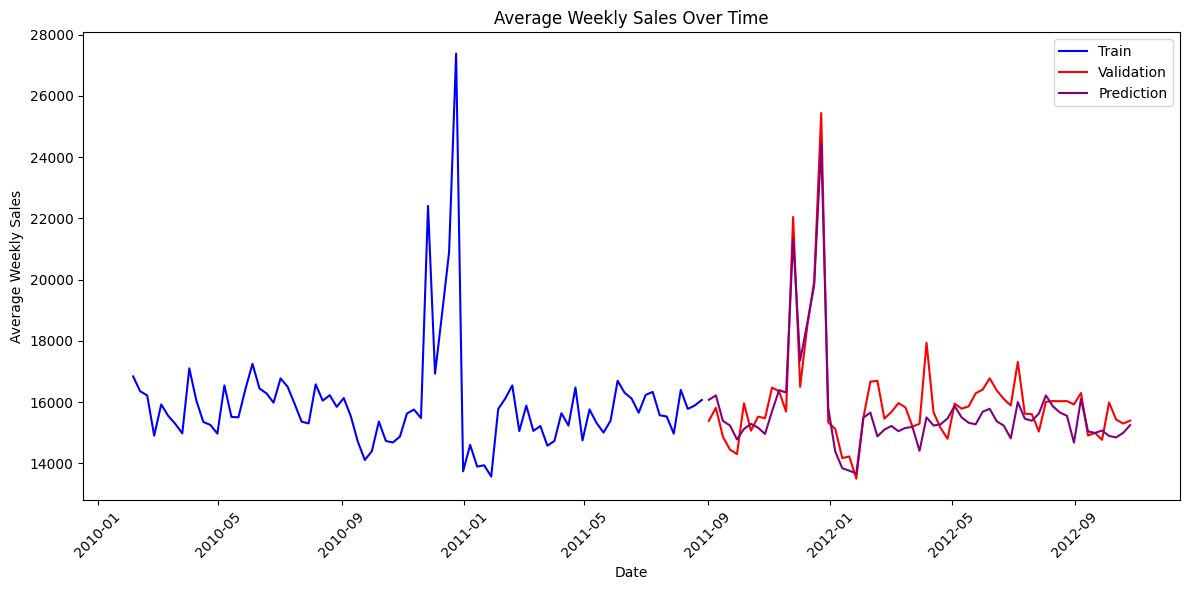

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [18:28:10] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/04 18:28:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_SquaredError_Estimator_50 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/83b2c6a79c104a04a4282762b7844768
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
log_experiment(model3)

## Experiment 4

In [223]:
class Model4(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_SquaredError_Estimator_100",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
      },
      'num_boost_round': 100,
    }

In [224]:
model4 = Model4(preprocessor_factory=preprocessor_factory1)
model4.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae'}, 'num_boost_round': 100}
[0]	train-mae:12099.41442	train-wmae:12099.41406	test-mae:12441.13561	test-wmae:12441.13477
[1]	train-mae:10088.84035	train-wmae:10088.83691	test-mae:10427.93009	test-wmae:10427.93066
[2]	train-mae:9039.72091	train-wmae:9039.72070	test-mae:9361.19315	test-wmae:9361.19238
[3]	train-mae:8291.39645	train-wmae:8291.39648	test-mae:8605.41074	test-wmae:8605.41016
[4]	train-mae:7592.52638	train-wmae:7592.52686	test-mae:7868.85911	test-wmae:7868.85938
[5]	train-mae:7033.36069	train-wmae:7033.36035	test-mae:7297.26162	test-wmae:7297.26172
[6]	train-mae:6697.45105	train-wmae:6697.45117	test-mae:6955.95090	test-wmae:6955.95020
[7]	train-mae:6305.78547	train-wmae:6305.78467	test-mae:6586.02921	test-wmae:6586.02930
[8]	train-mae:6060.30066	train-wmae:6060.30029	test-mae:6351.16099	test-wmae:6351.16260
[9]	train-mae:5879.55288	train-wmae:5879.55273	test-mae:6212.39136	test-wmae:6212.3906

Model Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae'}, 'num_boost_round': 100}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 2836.449533380781, 'mae_test': 3554.092786513485, 'wmae_train': np.float64(2887.015479419683), 'wmae_test': np.float64(3707.861059151612)}
Model Data {'run_name': 'XGBoost_Obj_SquaredError_Estimator_100', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


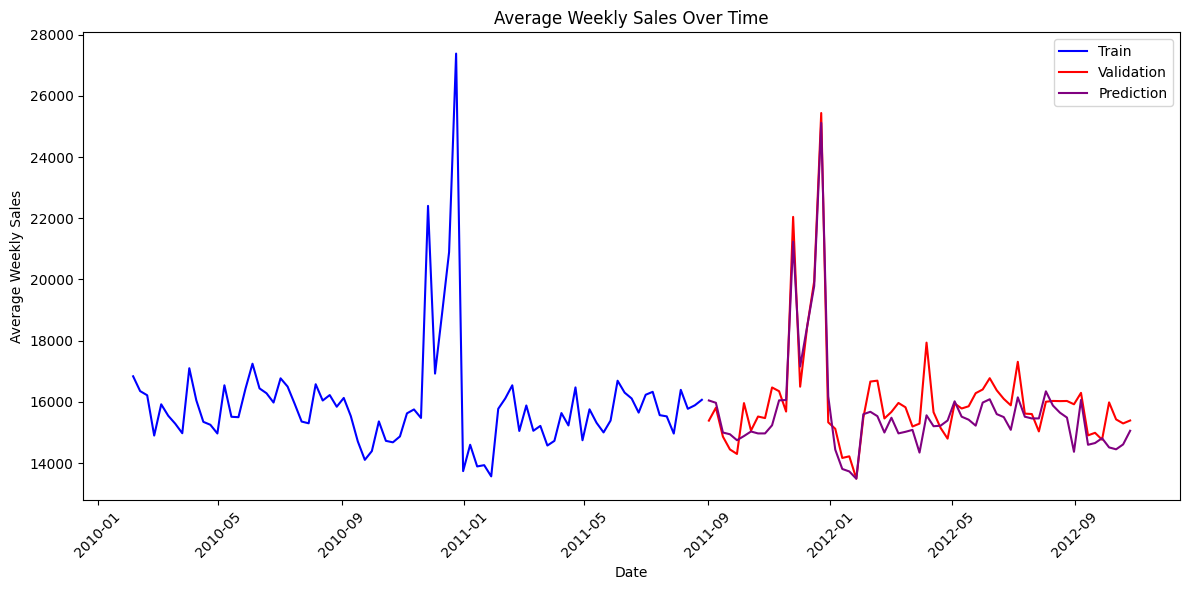

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [19:16:36] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/04 19:16:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_SquaredError_Estimator_100 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/0880a1c4d07a403088316c552b04b464
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [225]:
log_experiment(model4)

## Experiment 5

In [60]:
class Model5(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_SquaredError_Estimator_200",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
      },
      'num_boost_round': 200,
    }

In [61]:
model5 = Model5(preprocessor_factory=preprocessor_factory1)
model5.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae'}, 'num_boost_round': 200}
[0]	train-mae:12099.41442	train-wmae:12099.41406	test-mae:12441.13561	test-wmae:12441.13477
[1]	train-mae:10088.84035	train-wmae:10088.83691	test-mae:10427.93009	test-wmae:10427.93066
[2]	train-mae:9039.72091	train-wmae:9039.72070	test-mae:9361.19315	test-wmae:9361.19238
[3]	train-mae:8291.39645	train-wmae:8291.39648	test-mae:8605.41074	test-wmae:8605.41016
[4]	train-mae:7592.52638	train-wmae:7592.52686	test-mae:7868.85911	test-wmae:7868.85938
[5]	train-mae:7033.36069	train-wmae:7033.36035	test-mae:7297.26162	test-wmae:7297.26172
[6]	train-mae:6697.45105	train-wmae:6697.45117	test-mae:6955.95090	test-wmae:6955.95020
[7]	train-mae:6305.78547	train-wmae:6305.78467	test-mae:6586.02921	test-wmae:6586.02930
[8]	train-mae:6060.30066	train-wmae:6060.30029	test-mae:6351.16099	test-wmae:6351.16260
[9]	train-mae:5879.55288	train-wmae:5879.55273	test-mae:6212.39136	test-wmae:6212.3906

Model Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae'}, 'num_boost_round': 200}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 2333.30269210183, 'mae_test': 3369.795934797164, 'wmae_train': np.float64(2350.272432798231), 'wmae_test': np.float64(3505.5818113659448)}
Model Data {'run_name': 'XGBoost_Obj_SquaredError_Estimator_200', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


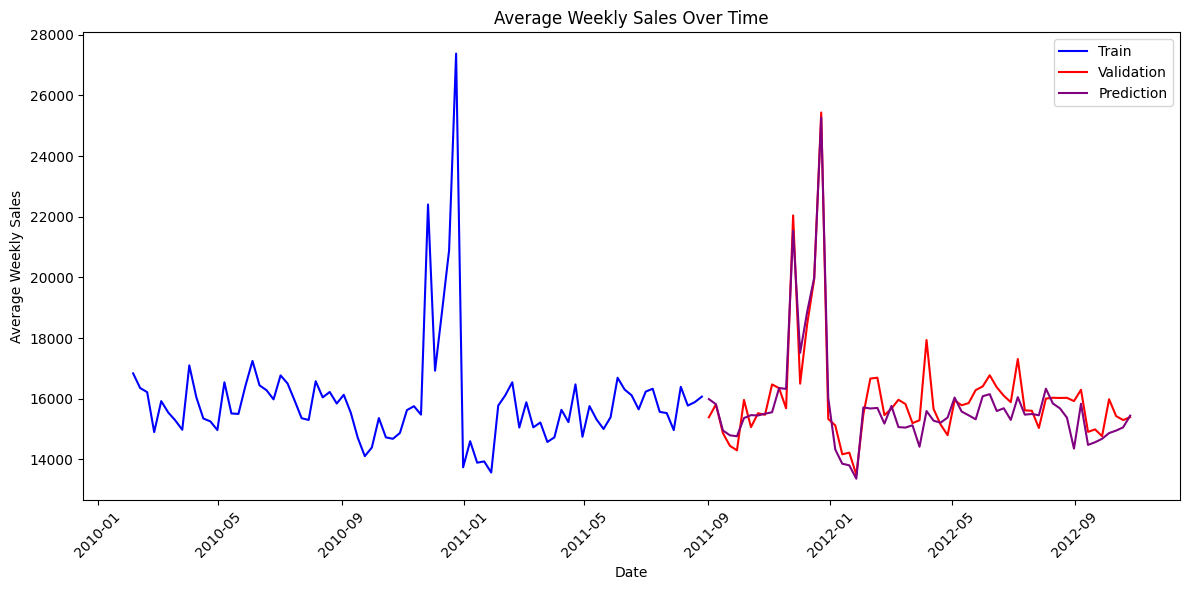

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [19:18:28] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/04 19:18:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_SquaredError_Estimator_200 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/38aa486a228144f2a599cb6d30700c2a
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [228]:
log_experiment(model5)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


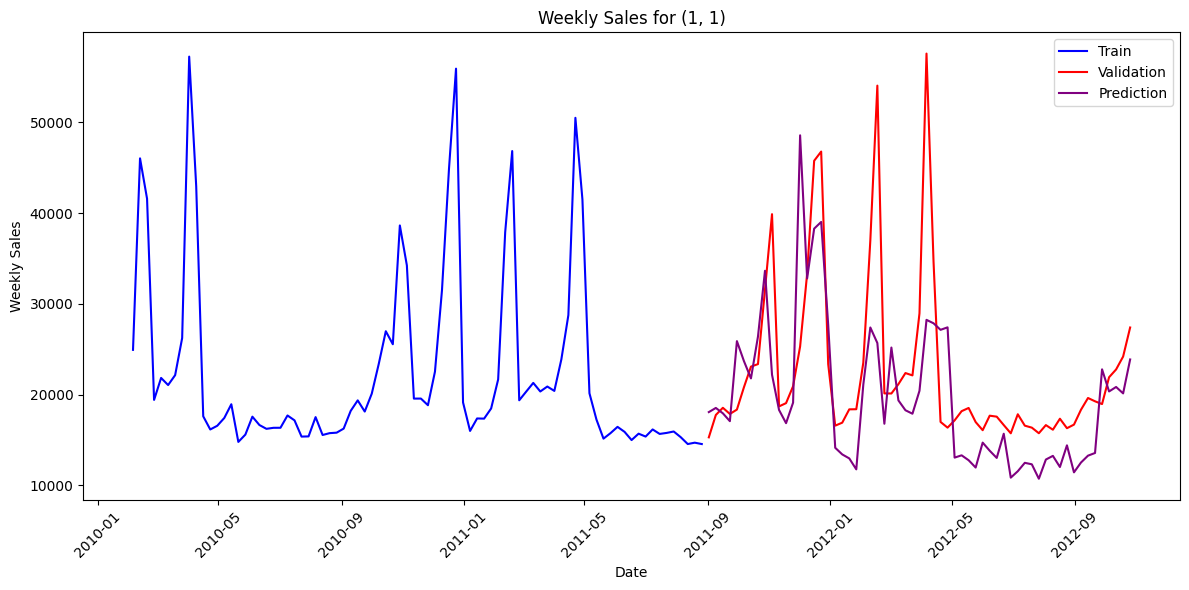

In [62]:
plot_store_dept(model5, 1, 1)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


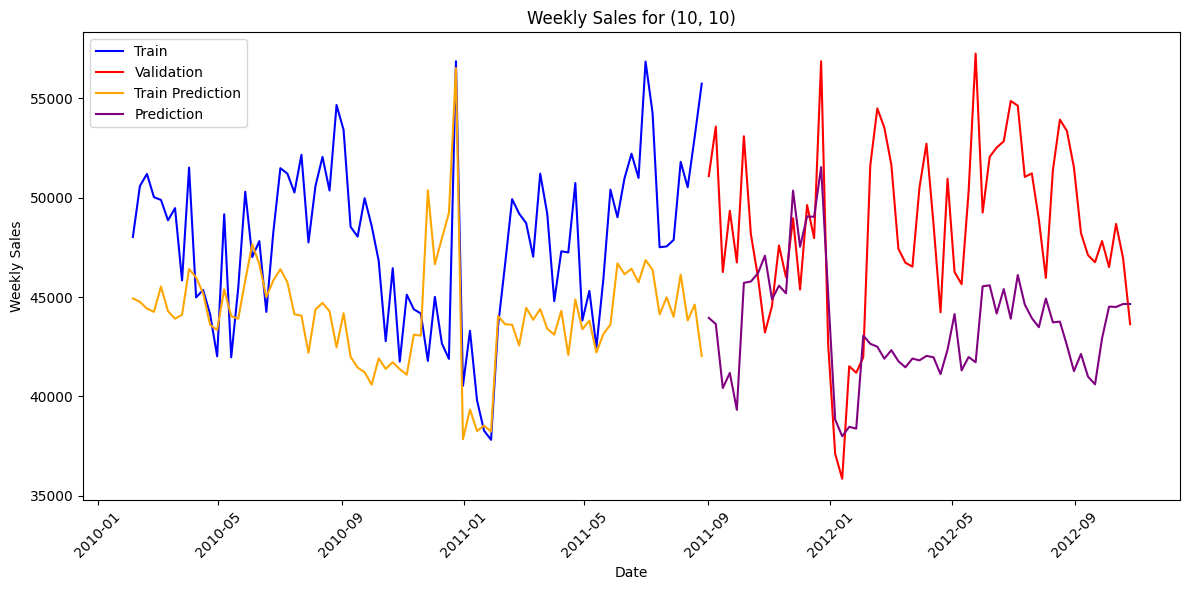

In [78]:
plot_store_dept(model5, 10, 10)

## Experiment 6

In [229]:
class Model6(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_AbsoluteError_Estimator_1",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:absoluteerror',
        'eval_metric': 'mae',
      },
      'num_boost_round': 1,
    }

In [230]:
model6 = Model6(preprocessor_factory=preprocessor_factory1)
model6.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae'}, 'num_boost_round': 1}
[0]	train-mae:11248.18664	train-wmae:11248.18848	test-mae:11582.63117	test-wmae:11582.63184


Model Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae'}, 'num_boost_round': 1}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 11075.31378309588, 'mae_test': 11305.03717124261, 'wmae_train': np.float64(11248.186628292535), 'wmae_test': np.float64(11582.631160385079)}
Model Data {'run_name': 'XGBoost_Obj_AbsoluteError_Estimator_1', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


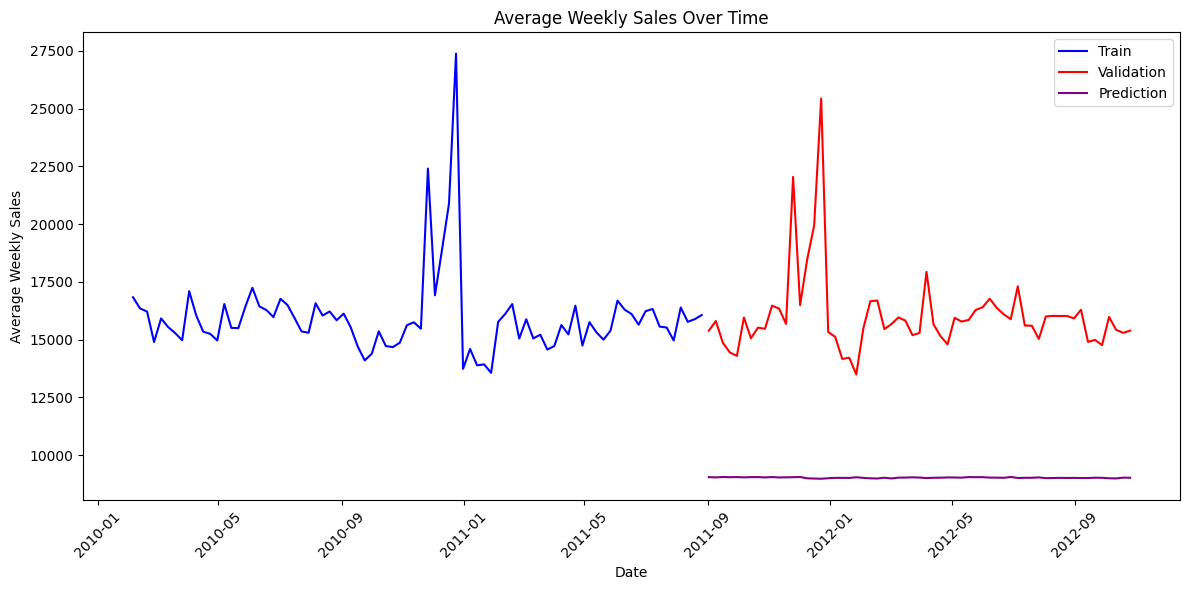

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [19:33:06] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/04 19:33:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_AbsoluteError_Estimator_1 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/c7f9a37a6b5c49b291cf8453f15cf288
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [231]:
log_experiment(model6)

In [232]:
class Model7(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_AbsoluteError_Estimator_50",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:absoluteerror',
        'eval_metric': 'mae',
      },
      'num_boost_round': 50,
    }

In [233]:
model7 = Model7(preprocessor_factory=preprocessor_factory1)
model7.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae'}, 'num_boost_round': 50}
[0]	train-mae:11248.18664	train-wmae:11248.18848	test-mae:11582.63117	test-wmae:11582.63184
[1]	train-mae:9668.42023	train-wmae:9668.41992	test-mae:10002.26337	test-wmae:10002.26269
[2]	train-mae:8826.74405	train-wmae:8826.74414	test-mae:9139.94716	test-wmae:9139.94727
[3]	train-mae:8308.49614	train-wmae:8308.49512	test-mae:8652.62017	test-wmae:8652.62012
[4]	train-mae:7837.62829	train-wmae:7837.62842	test-mae:8191.46013	test-wmae:8191.45996
[5]	train-mae:7546.92879	train-wmae:7546.92822	test-mae:7938.18278	test-wmae:7938.18164
[6]	train-mae:7275.94429	train-wmae:7275.94434	test-mae:7691.96843	test-wmae:7691.96777
[7]	train-mae:6978.79288	train-wmae:6978.79297	test-mae:7392.49917	test-wmae:7392.50000
[8]	train-mae:6698.64220	train-wmae:6698.64160	test-mae:7107.34162	test-wmae:7107.34082
[9]	train-mae:6486.85372	train-wmae:6486.85352	test-mae:6912.77441	test-wmae:6912.77441


Model Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae'}, 'num_boost_round': 50}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 3972.1484213578105, 'mae_test': 4487.6070995681275, 'wmae_train': np.float64(4134.530151673101), 'wmae_test': np.float64(4738.96125754854)}
Model Data {'run_name': 'XGBoost_Obj_AbsoluteError_Estimator_50', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


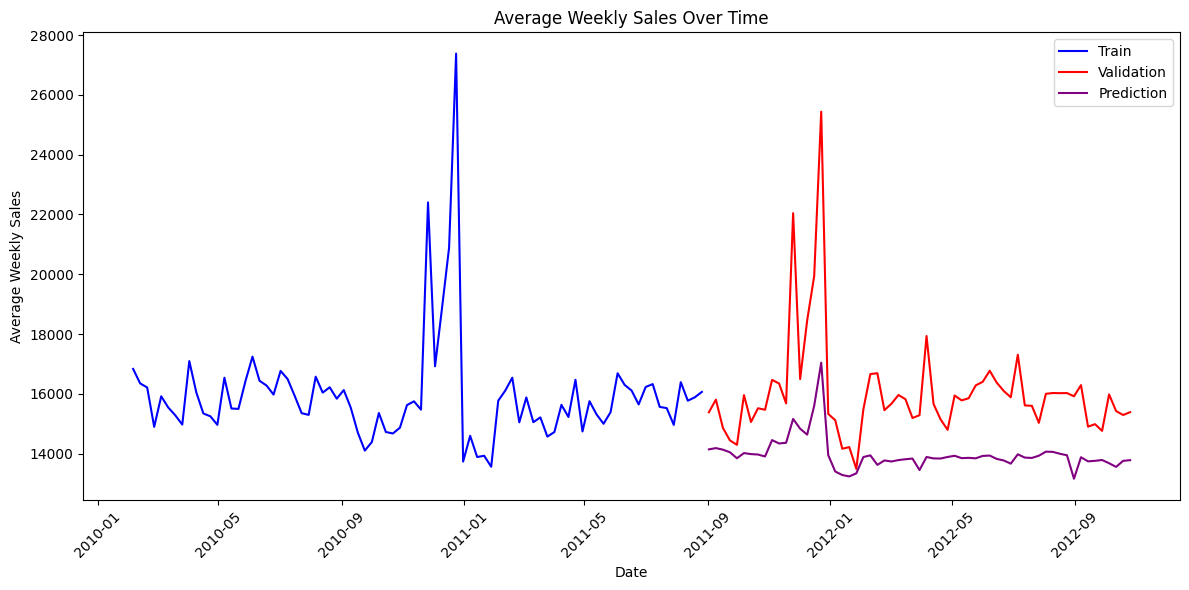

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [19:34:58] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/04 19:35:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_AbsoluteError_Estimator_50 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/169eac1a83d241e0bf35f99b69796c63
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [234]:
log_experiment(model7)

In [235]:
class Model8(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_AbsoluteError_Estimator_100",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:absoluteerror',
        'eval_metric': 'mae',
      },
      'num_boost_round': 100,
    }

In [236]:
model8 = Model8(preprocessor_factory=preprocessor_factory1)
model8.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae'}, 'num_boost_round': 100}
[0]	train-mae:11248.18664	train-wmae:11248.18848	test-mae:11582.63117	test-wmae:11582.63184
[1]	train-mae:9668.42023	train-wmae:9668.41992	test-mae:10002.26337	test-wmae:10002.26269
[2]	train-mae:8826.74405	train-wmae:8826.74414	test-mae:9139.94716	test-wmae:9139.94727
[3]	train-mae:8308.49614	train-wmae:8308.49512	test-mae:8652.62017	test-wmae:8652.62012
[4]	train-mae:7837.62829	train-wmae:7837.62842	test-mae:8191.46013	test-wmae:8191.45996
[5]	train-mae:7546.92879	train-wmae:7546.92822	test-mae:7938.18278	test-wmae:7938.18164
[6]	train-mae:7275.94429	train-wmae:7275.94434	test-mae:7691.96843	test-wmae:7691.96777
[7]	train-mae:6978.79288	train-wmae:6978.79297	test-mae:7392.49917	test-wmae:7392.50000
[8]	train-mae:6698.64220	train-wmae:6698.64160	test-mae:7107.34162	test-wmae:7107.34082
[9]	train-mae:6486.85372	train-wmae:6486.85352	test-mae:6912.77441	test-wmae:6912.77441

Model Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae'}, 'num_boost_round': 100}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 3251.7926921423286, 'mae_test': 3882.6473825704697, 'wmae_train': np.float64(3393.5045087223466), 'wmae_test': np.float64(4106.367590955688)}
Model Data {'run_name': 'XGBoost_Obj_AbsoluteError_Estimator_100', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


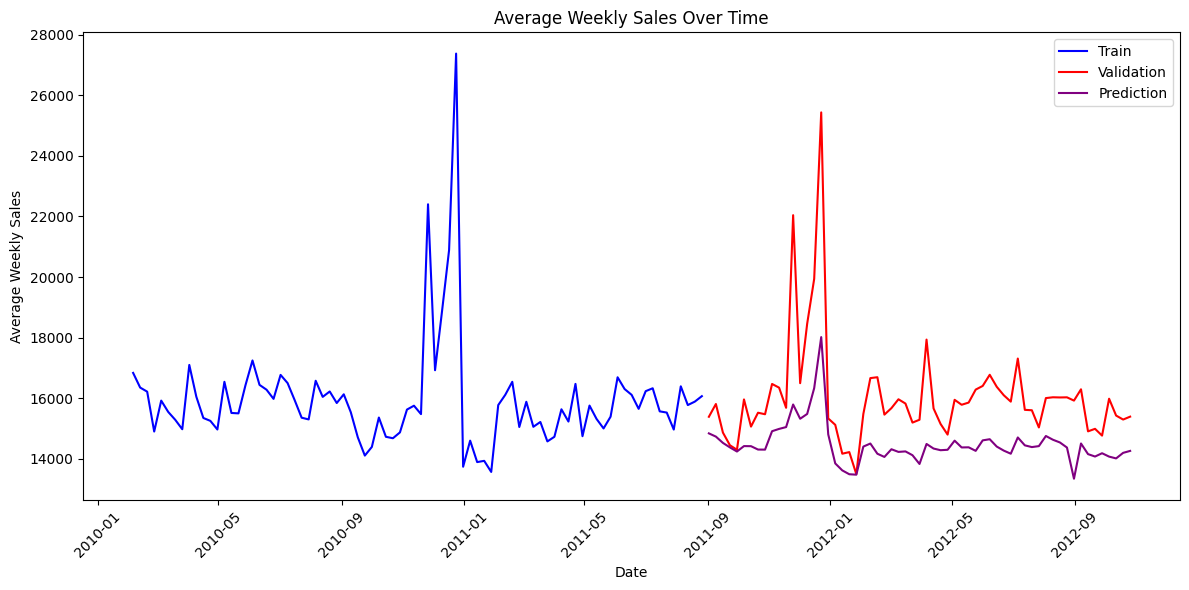

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [19:37:00] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/04 19:37:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_AbsoluteError_Estimator_100 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/7a0bcf1ed1af49b6bdf35628bc86b50f
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [237]:
log_experiment(model8)

In [35]:
class Model9(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_AbsoluteError_Estimator_100_HigherLR",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:absoluteerror',
        'eval_metric': 'mae',
        'eta': 0.2,
      },
      'num_boost_round': 100,
    }

In [36]:
model9 = Model9(preprocessor_factory=preprocessor_factory1)
model9.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae', 'eta': 0.2}, 'num_boost_round': 100}
[0]	train-mae:11943.33861	train-wmae:11943.33691	test-mae:12281.44622	test-wmae:12281.44824
[1]	train-mae:10861.96503	train-wmae:10861.96484	test-mae:11198.86550	test-wmae:11198.86523
[2]	train-mae:10077.85070	train-wmae:10077.85156	test-mae:10415.88593	test-wmae:10415.88574
[3]	train-mae:9245.93387	train-wmae:9245.93359	test-mae:9603.25886	test-wmae:9603.25879
[4]	train-mae:8854.90155	train-wmae:8854.90039	test-mae:9219.30543	test-wmae:9219.30566
[5]	train-mae:8526.11332	train-wmae:8526.11328	test-mae:8896.27473	test-wmae:8896.27441
[6]	train-mae:8227.56597	train-wmae:8227.56641	test-mae:8599.34722	test-wmae:8599.34668
[7]	train-mae:7957.71311	train-wmae:7957.71191	test-mae:8322.36890	test-wmae:8322.36816
[8]	train-mae:7823.08001	train-wmae:7823.07910	test-mae:8191.88771	test-wmae:8191.88867
[9]	train-mae:7615.55702	train-wmae:7615.55615	test-mae:7989.59811	te

Model Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae', 'eta': 0.2}, 'num_boost_round': 100}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 3501.5863772570683, 'mae_test': 3982.4765484551144, 'wmae_train': np.float64(3649.768545723227), 'wmae_test': np.float64(4218.194824268481)}
Model Data {'run_name': 'XGBoost_Obj_AbsoluteError_Estimator_100_HigherLR', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


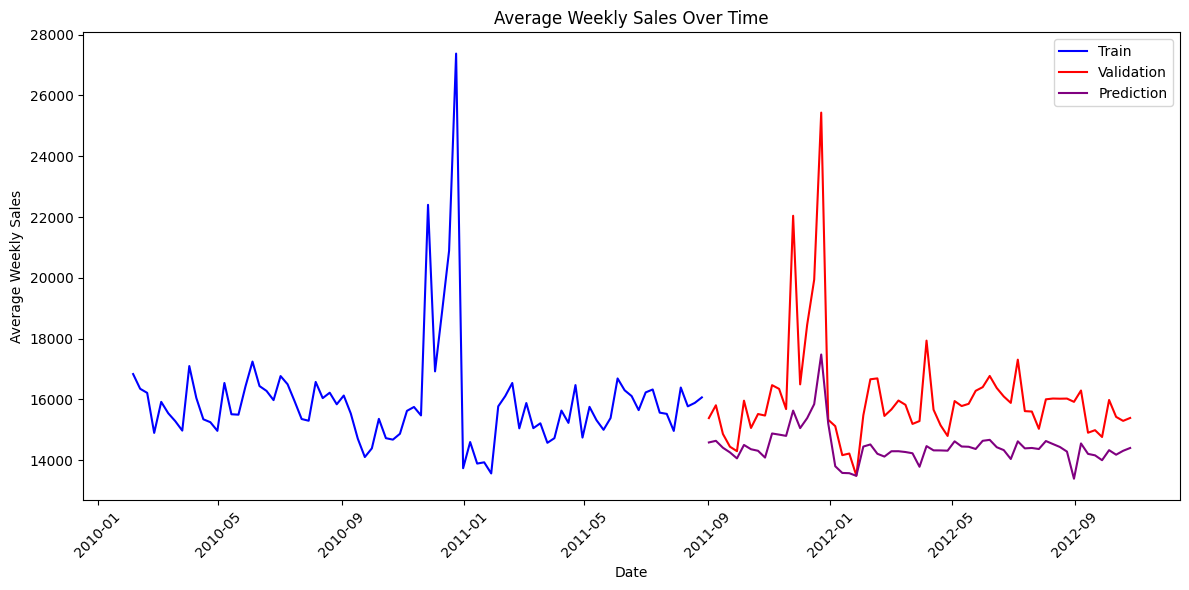

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [19:41:40] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/04 19:41:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_AbsoluteError_Estimator_100_HigherLR at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/d647f1d8883a4bc59f2690cdb365c670
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [253]:
log_experiment(model9)

## Experiment 10

In [38]:
class Model10(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_AbsoluteError_Estimator_200_HigherLR",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:absoluteerror',
        'eval_metric': 'mae',
        'eta': 0.2,
      },
      'num_boost_round': 200,
    }

In [39]:
model10 = Model10(preprocessor_factory=preprocessor_factory1)
model10.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae', 'eta': 0.2}, 'num_boost_round': 200}
[0]	train-mae:11943.33861	train-wmae:11943.33691	test-mae:12281.44622	test-wmae:12281.44824
[1]	train-mae:10861.96503	train-wmae:10861.96484	test-mae:11198.86550	test-wmae:11198.86523
[2]	train-mae:10077.85070	train-wmae:10077.85156	test-mae:10415.88593	test-wmae:10415.88574
[3]	train-mae:9245.93387	train-wmae:9245.93359	test-mae:9603.25886	test-wmae:9603.25879
[4]	train-mae:8854.90155	train-wmae:8854.90039	test-mae:9219.30543	test-wmae:9219.30566
[5]	train-mae:8526.11332	train-wmae:8526.11328	test-mae:8896.27473	test-wmae:8896.27441
[6]	train-mae:8227.56597	train-wmae:8227.56641	test-mae:8599.34722	test-wmae:8599.34668
[7]	train-mae:7957.71311	train-wmae:7957.71191	test-mae:8322.36890	test-wmae:8322.36816
[8]	train-mae:7823.08001	train-wmae:7823.07910	test-mae:8191.88771	test-wmae:8191.88867
[9]	train-mae:7615.55702	train-wmae:7615.55615	test-mae:7989.59811	te

Model Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae', 'eta': 0.2}, 'num_boost_round': 200}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 2956.6041536645034, 'mae_test': 3603.8863546155676, 'wmae_train': np.float64(3087.312786586592), 'wmae_test': np.float64(3824.558317655287)}
Model Data {'run_name': 'XGBoost_Obj_AbsoluteError_Estimator_200_HigherLR', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


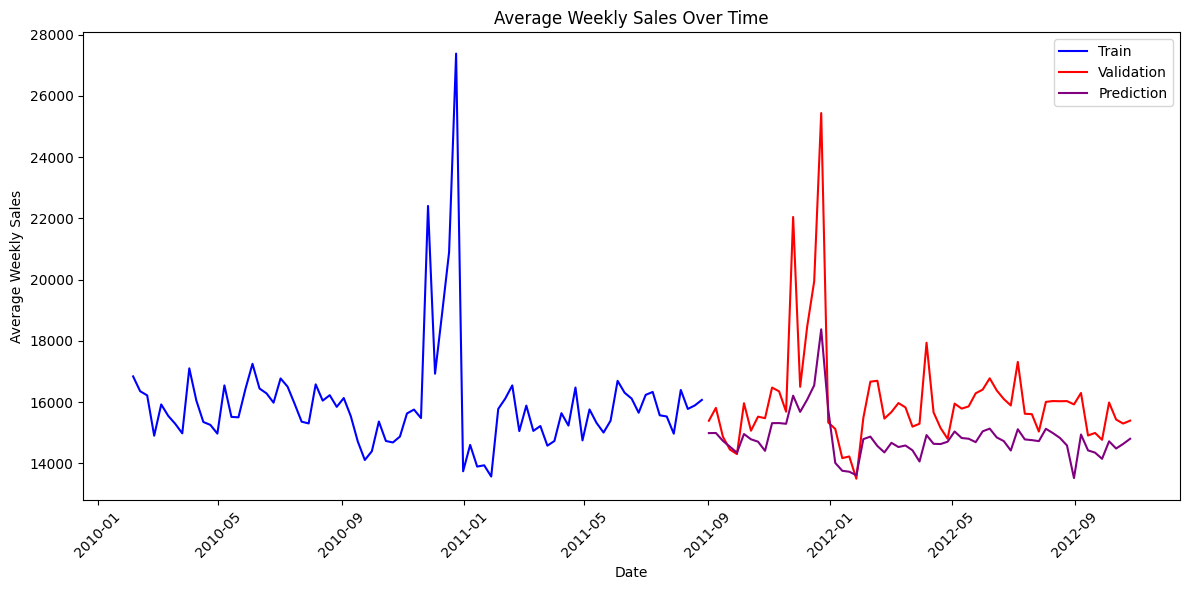

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [11:32:59] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/05 11:33:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_AbsoluteError_Estimator_200_HigherLR at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/013e2ffe085847bca641b2f370a7ccd9
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [40]:
log_experiment(model10)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


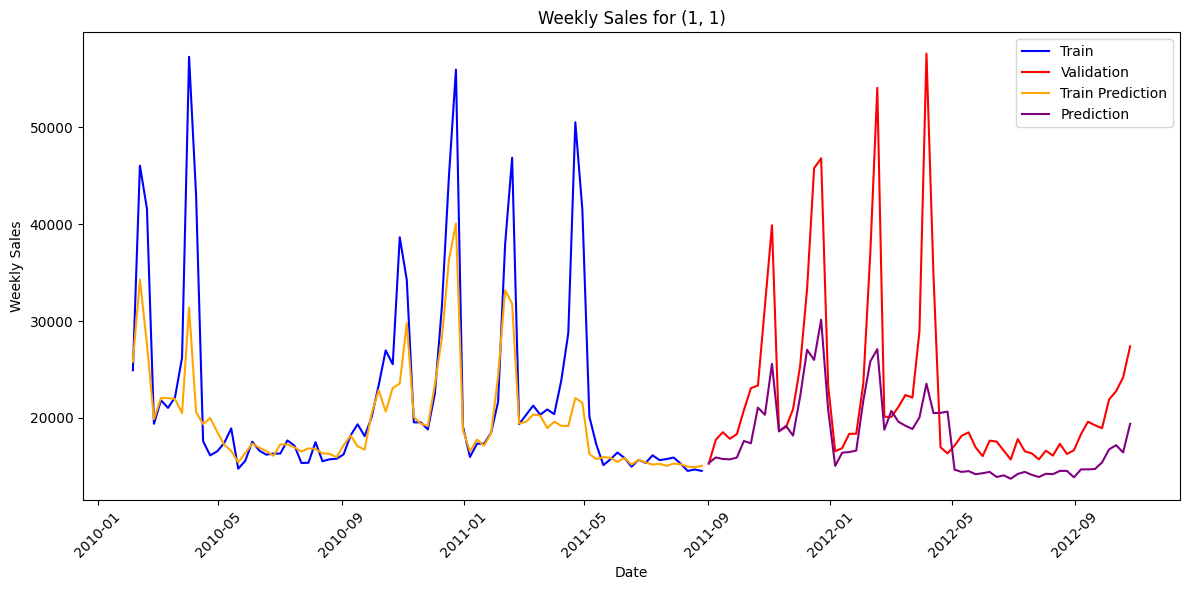

In [75]:
plot_store_dept(model10, 1, 1)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


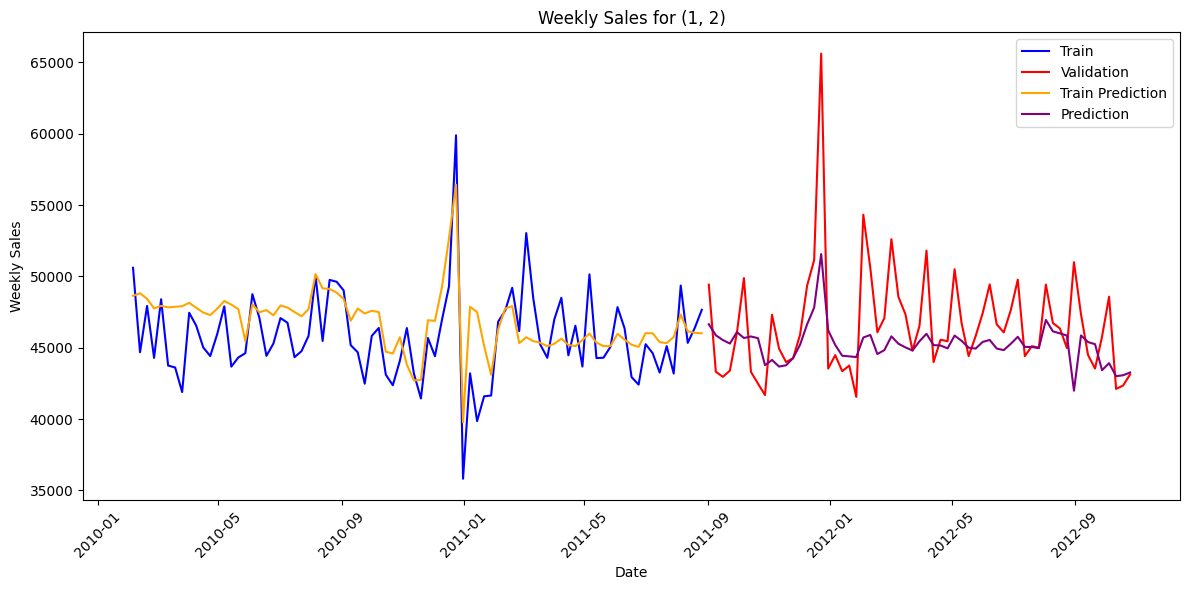

In [76]:
plot_store_dept(model10, 1, 2)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


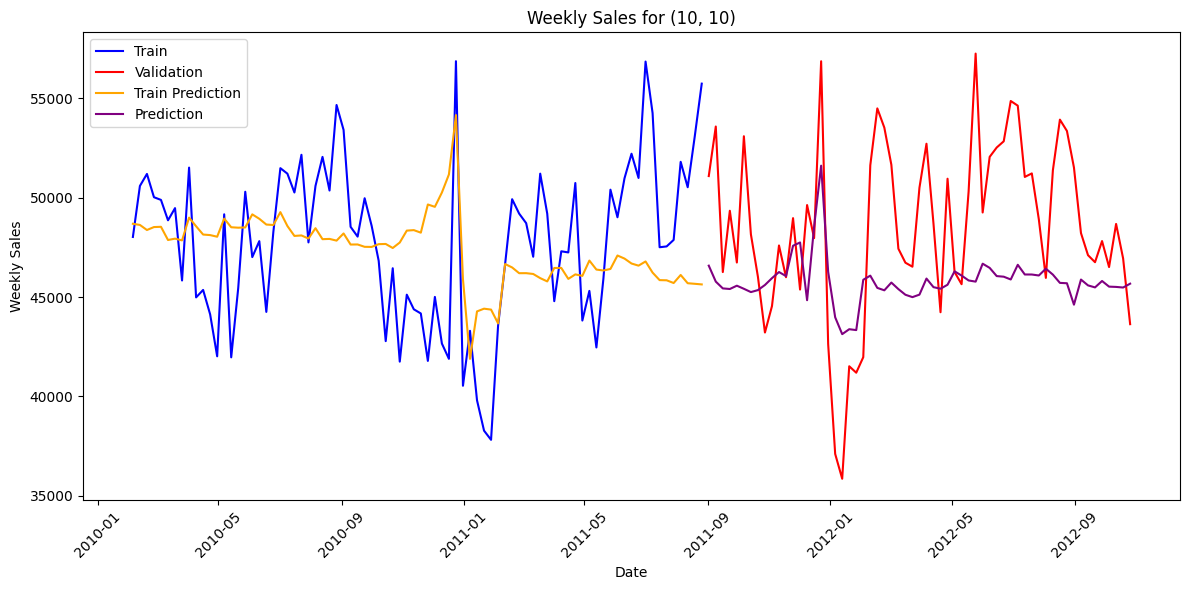

In [77]:
plot_store_dept(model10, 10, 10)

## Experiment 11

In [41]:
class Model11(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_HuberError_Estimator_100",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:pseudohubererror',
        'eval_metric': 'mae',
      },
      'num_boost_round': 100,
    }

In [42]:
model11 = Model11(preprocessor_factory=preprocessor_factory1)
model11.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:pseudohubererror', 'eval_metric': 'mae'}, 'num_boost_round': 100}
[0]	train-mae:12693.92110	train-wmae:12693.92188	test-mae:13128.05911	test-wmae:13128.05762
[1]	train-mae:11980.70349	train-wmae:11980.70508	test-mae:12321.98083	test-wmae:12321.98242
[2]	train-mae:11577.08114	train-wmae:11577.08203	test-mae:11930.82606	test-wmae:11930.82519
[3]	train-mae:11458.59826	train-wmae:11458.59863	test-mae:11814.84415	test-wmae:11814.84473
[4]	train-mae:11254.08276	train-wmae:11254.08203	test-mae:11597.49229	test-wmae:11597.49316
[5]	train-mae:11120.30221	train-wmae:11120.30371	test-mae:11462.33707	test-wmae:11462.33691
[6]	train-mae:11003.30336	train-wmae:11003.30273	test-mae:11355.19767	test-wmae:11355.19629
[7]	train-mae:10916.02816	train-wmae:10916.02734	test-mae:11276.02148	test-wmae:11276.02246
[8]	train-mae:10838.21361	train-wmae:10838.21289	test-mae:11204.32300	test-wmae:11204.32324
[9]	train-mae:10740.31026	train-wmae:10740.31055	test-

Model Training Params {'params': {'objective': 'reg:pseudohubererror', 'eval_metric': 'mae'}, 'num_boost_round': 100}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 7089.928259939491, 'mae_test': 7496.6135887638, 'wmae_train': np.float64(7258.1903718687), 'wmae_test': np.float64(7751.121990001502)}
Model Data {'run_name': 'XGBoost_Obj_HuberError_Estimator_100', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


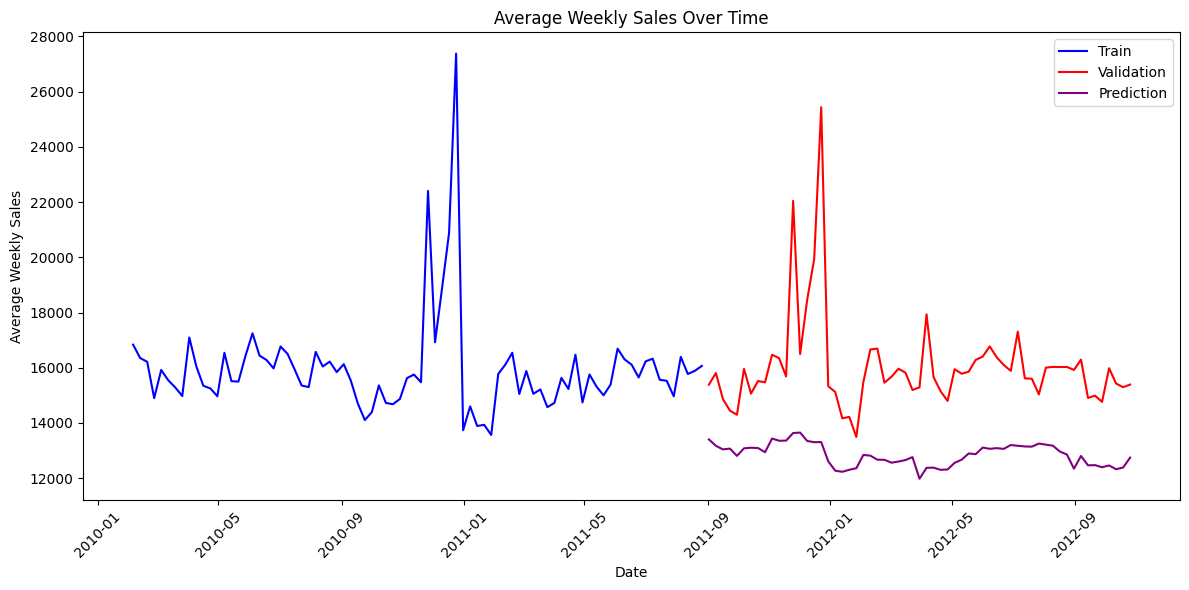

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [11:38:47] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/05 11:38:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_HuberError_Estimator_100 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/884d1229000847a6a51175318fbf76d6
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [43]:
log_experiment(model11)

## Experiment 12

In [44]:
class Model12(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_HuberError_Estimator_300",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:pseudohubererror',
        'eval_metric': 'mae',
      },
      'num_boost_round': 300,
    }

In [45]:
model12 = Model12(preprocessor_factory=preprocessor_factory1)
model12.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:pseudohubererror', 'eval_metric': 'mae'}, 'num_boost_round': 300}
[0]	train-mae:12693.92110	train-wmae:12693.92188	test-mae:13128.05911	test-wmae:13128.05762
[1]	train-mae:11980.70349	train-wmae:11980.70508	test-mae:12321.98083	test-wmae:12321.98242
[2]	train-mae:11577.08114	train-wmae:11577.08203	test-mae:11930.82606	test-wmae:11930.82519
[3]	train-mae:11458.59826	train-wmae:11458.59863	test-mae:11814.84415	test-wmae:11814.84473
[4]	train-mae:11254.08276	train-wmae:11254.08203	test-mae:11597.49229	test-wmae:11597.49316
[5]	train-mae:11120.30221	train-wmae:11120.30371	test-mae:11462.33707	test-wmae:11462.33691
[6]	train-mae:11003.30336	train-wmae:11003.30273	test-mae:11355.19767	test-wmae:11355.19629
[7]	train-mae:10916.02816	train-wmae:10916.02734	test-mae:11276.02148	test-wmae:11276.02246
[8]	train-mae:10838.21361	train-wmae:10838.21289	test-mae:11204.32300	test-wmae:11204.32324
[9]	train-mae:10740.31026	train-wmae:10740.31055	test-

Model Training Params {'params': {'objective': 'reg:pseudohubererror', 'eval_metric': 'mae'}, 'num_boost_round': 300}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 5537.680074727412, 'mae_test': 6059.472693378056, 'wmae_train': np.float64(5709.7024961570805), 'wmae_test': np.float64(6310.386459912457)}
Model Data {'run_name': 'XGBoost_Obj_HuberError_Estimator_300', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


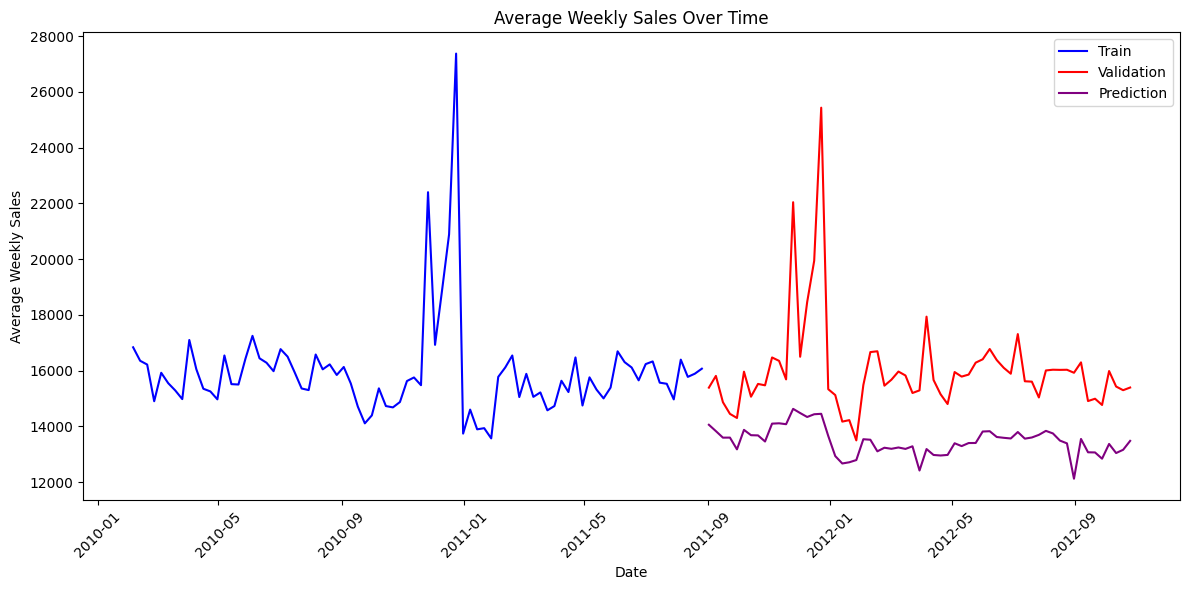

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [11:42:19] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/05 11:42:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_HuberError_Estimator_300 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/8b8839848b5f4a8eaad01ff73ad5dc7a
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [46]:
log_experiment(model12)

## Experiment 13

In [49]:
class Model13(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_HuberError_Estimator_300_Slope_05",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:pseudohubererror',
        'eval_metric': 'mae',
        'huber_slope': 0.5,
      },
      'num_boost_round': 300,
    }

In [50]:
model13 = Model13(preprocessor_factory=preprocessor_factory1)
model13.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:pseudohubererror', 'eval_metric': 'mae', 'huber_slope': 0.5}, 'num_boost_round': 300}
[0]	train-mae:13568.52962	train-wmae:13568.52930	test-mae:13964.15429	test-wmae:13964.15527
[1]	train-mae:12669.88639	train-wmae:12669.88574	test-mae:13067.18400	test-wmae:13067.18262
[2]	train-mae:12221.61089	train-wmae:12221.61133	test-mae:12617.08708	test-wmae:12617.08594
[3]	train-mae:12023.91731	train-wmae:12023.91504	test-mae:12410.95901	test-wmae:12410.95996
[4]	train-mae:11828.40070	train-wmae:11828.40137	test-mae:12205.72379	test-wmae:12205.72363
[5]	train-mae:11665.29996	train-wmae:11665.29981	test-mae:12063.77928	test-wmae:12063.78027
[6]	train-mae:11515.23973	train-wmae:11515.23926	test-mae:11932.94680	test-wmae:11932.94727
[7]	train-mae:11382.61200	train-wmae:11382.61231	test-mae:11807.78843	test-wmae:11807.78711
[8]	train-mae:11291.90116	train-wmae:11291.90137	test-mae:11705.32920	test-wmae:11705.32910
[9]	train-mae:11194.58930	train-wm

Model Training Params {'params': {'objective': 'reg:pseudohubererror', 'eval_metric': 'mae', 'huber_slope': 0.5}, 'num_boost_round': 300}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 6924.995903228182, 'mae_test': 7296.013974908372, 'wmae_train': np.float64(7087.356122668019), 'wmae_test': np.float64(7562.739296835187)}
Model Data {'run_name': 'XGBoost_Obj_HuberError_Estimator_300_Slope_05', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


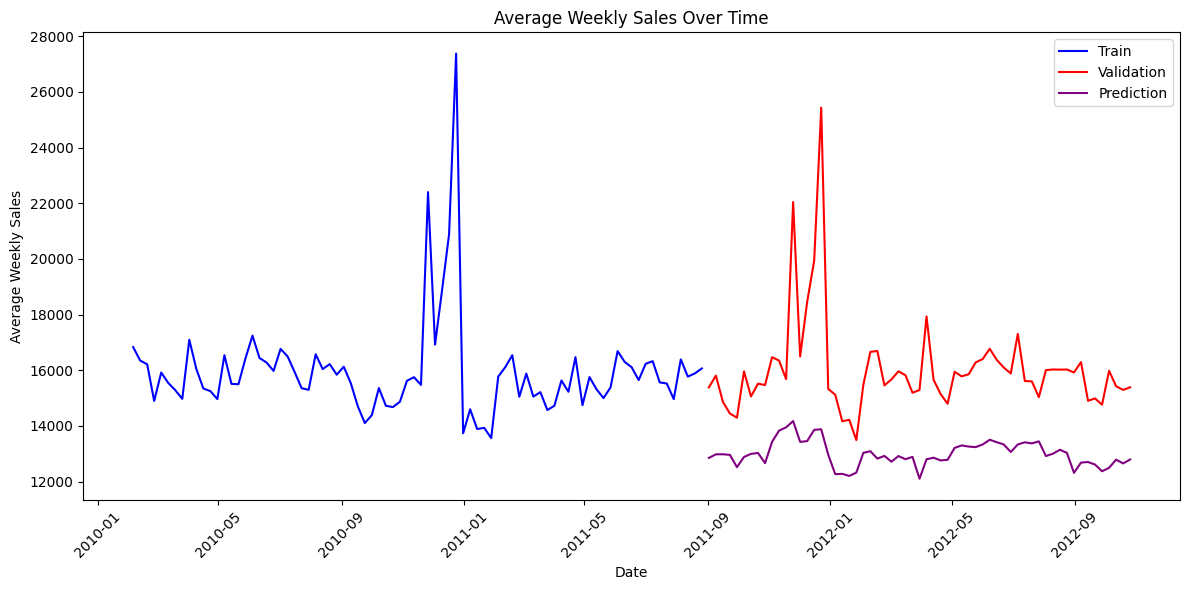

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [11:46:46] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/05 11:46:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_HuberError_Estimator_300_Slope_05 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/db77359bb8af49e4b350a7c8cd8184e9
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [51]:
log_experiment(model13)

## Experiment 14

In [54]:
class Model14(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_HuberError_Estimator_300_SlopeSearch",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:pseudohubererror',
        'eval_metric': 'mae',
      },
      'num_boost_round': 300,
    }

In [55]:
models = []

for huber_slope in [0.3, 0.7, 1.2, 1.5]:
  model = Model14(preprocessor_factory=preprocessor_factory1)
  model.train_params['params']['huber_slope'] = huber_slope
  model.train(X_train, y_train, X_test, y_test)
  print(model.get_metrics(X_train, y_train, X_test, y_test))
  models.append(model)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:pseudohubererror', 'eval_metric': 'mae', 'huber_slope': 0.3}, 'num_boost_round': 300}
[0]	train-mae:14390.47835	train-wmae:14390.47949	test-mae:14742.02885	test-wmae:14742.02832
[1]	train-mae:13596.91124	train-wmae:13596.91016	test-mae:13987.30428	test-wmae:13987.30371
[2]	train-mae:13035.61949	train-wmae:13035.62012	test-mae:13450.79079	test-wmae:13450.79199
[3]	train-mae:12773.02188	train-wmae:12773.02246	test-mae:13172.44044	test-wmae:13172.44238
[4]	train-mae:12606.57949	train-wmae:12606.57812	test-mae:13010.81172	test-wmae:13010.81152
[5]	train-mae:12435.82660	train-wmae:12435.82812	test-mae:12838.95027	test-wmae:12838.94824
[6]	train-mae:12167.70820	train-wmae:12167.70801	test-mae:12582.01090	test-wmae:12582.01269
[7]	train-mae:11966.84305	train-wmae:11966.84277	test-mae:12384.51153	test-wmae:12384.50977
[8]	train-mae:11818.84435	train-wmae:11818.84570	test-mae:12233.54175	test-wmae:12233.54199
[9]	train-mae:11749.53541	train-wm

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


{'mae_train': 8148.638645720492, 'mae_test': 8559.662557982212, 'wmae_train': np.float64(8311.706778746115), 'wmae_test': np.float64(8823.777110157813)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:pseudohubererror', 'eval_metric': 'mae', 'huber_slope': 0.7}, 'num_boost_round': 300}
[0]	train-mae:13869.55686	train-wmae:13869.55762	test-mae:14097.88716	test-wmae:14097.88672
[1]	train-mae:13019.11218	train-wmae:13019.11133	test-mae:13375.20750	test-wmae:13375.20703
[2]	train-mae:12181.89659	train-wmae:12181.89746	test-mae:12495.68120	test-wmae:12495.68066
[3]	train-mae:11754.74249	train-wmae:11754.74023	test-mae:12119.66015	test-wmae:12119.65918
[4]	train-mae:11518.67262	train-wmae:11518.67285	test-mae:11889.06683	test-wmae:11889.06641
[5]	train-mae:11320.66835	train-wmae:11320.66894	test-mae:11701.39619	test-wmae:11701.39746
[6]	train-mae:11239.04291	train-wmae:11239.04394	test-mae:11619.46273	test-wmae:11619.46094
[7]	train-mae:11132.76286	train-wmae:11132.76269	test-mae:11517.62216	test-wmae:11517.62109
[8]	train-mae:10998.03045	train-wmae:10998.03027	test-mae:11380.57125	test-wmae:11380.57129
[9]	train-mae:10921.30919	train-wm

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


{'mae_train': 6057.914077261071, 'mae_test': 6455.923241865547, 'wmae_train': np.float64(6223.287957413728), 'wmae_test': np.float64(6717.708725706251)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:pseudohubererror', 'eval_metric': 'mae', 'huber_slope': 1.2}, 'num_boost_round': 300}
[0]	train-mae:13103.01822	train-wmae:13103.01758	test-mae:13825.54025	test-wmae:13825.54102
[1]	train-mae:12111.91671	train-wmae:12111.91602	test-mae:12793.03477	test-wmae:12793.03320
[2]	train-mae:11360.59810	train-wmae:11360.59961	test-mae:11928.66924	test-wmae:11928.67090
[3]	train-mae:11023.82957	train-wmae:11023.82812	test-mae:11592.64623	test-wmae:11592.64356
[4]	train-mae:10692.15124	train-wmae:10692.15137	test-mae:11232.31069	test-wmae:11232.31152
[5]	train-mae:10575.95890	train-wmae:10575.95898	test-mae:11105.14631	test-wmae:11105.14648
[6]	train-mae:10450.39480	train-wmae:10450.39453	test-mae:10963.90806	test-wmae:10963.90723
[7]	train-mae:10354.19715	train-wmae:10354.19531	test-mae:10868.49363	test-wmae:10868.49512
[8]	train-mae:10214.20012	train-wmae:10214.20019	test-mae:10704.40890	test-wmae:10704.40820
[9]	train-mae:10083.36181	train-wm

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


{'mae_train': 5183.623530759283, 'mae_test': 5740.829044996796, 'wmae_train': np.float64(5365.5183511411105), 'wmae_test': np.float64(6005.888951612397)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:pseudohubererror', 'eval_metric': 'mae', 'huber_slope': 1.5}, 'num_boost_round': 300}
[0]	train-mae:13172.54802	train-wmae:13172.54785	test-mae:13585.78044	test-wmae:13585.78125
[1]	train-mae:12279.45525	train-wmae:12279.45508	test-mae:12695.44646	test-wmae:12695.44727
[2]	train-mae:11571.67105	train-wmae:11571.66992	test-mae:11993.02617	test-wmae:11993.02539
[3]	train-mae:11225.77840	train-wmae:11225.77832	test-mae:11646.77620	test-wmae:11646.77539
[4]	train-mae:10996.39457	train-wmae:10996.39356	test-mae:11442.03276	test-wmae:11442.03320
[5]	train-mae:10873.34648	train-wmae:10873.34766	test-mae:11314.90278	test-wmae:11314.90234
[6]	train-mae:10659.16499	train-wmae:10659.16211	test-mae:11088.15014	test-wmae:11088.14941
[7]	train-mae:10538.34332	train-wmae:10538.34375	test-mae:10959.57687	test-wmae:10959.57910
[8]	train-mae:10448.09101	train-wmae:10448.09180	test-mae:10875.03412	test-wmae:10875.03418
[9]	train-mae:10235.65831	train-wm

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


{'mae_train': 4902.699447354279, 'mae_test': 5400.600566239042, 'wmae_train': np.float64(5079.295880320592), 'wmae_test': np.float64(5671.239163794439)}


Model Training Params {'params': {'objective': 'reg:pseudohubererror', 'eval_metric': 'mae', 'huber_slope': 1.5}, 'num_boost_round': 300}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 4902.699447354279, 'mae_test': 5400.600566239042, 'wmae_train': np.float64(5079.295880320592), 'wmae_test': np.float64(5671.239163794439)}
Model Data {'run_name': 'XGBoost_Obj_HuberError_Estimator_300_SlopeSearch', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


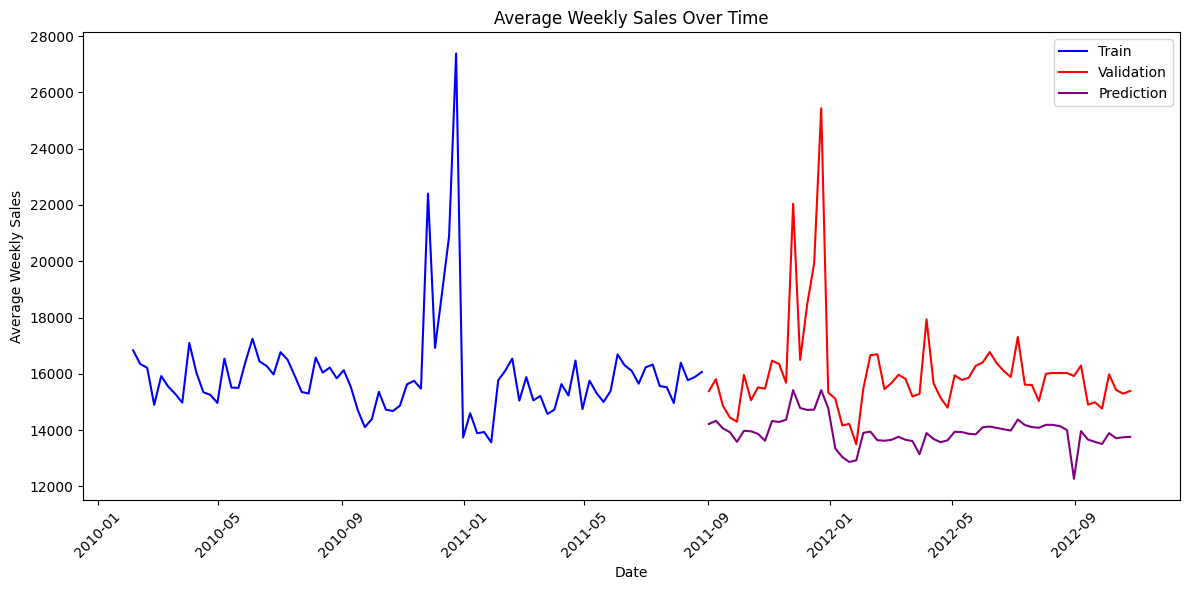

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [11:59:47] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/05 11:59:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_HuberError_Estimator_300_SlopeSearch at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/17a2836293464403b268fa114620ed22
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [56]:
log_experiment(models[-1])

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


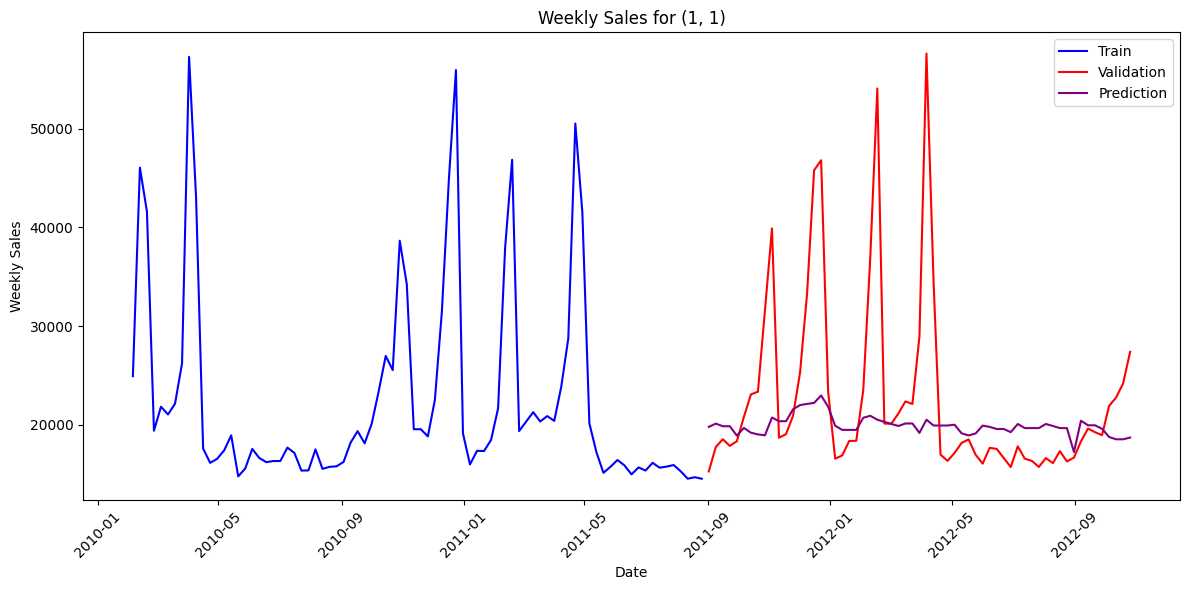

In [59]:
plot_store_dept(models[-1], 1, 1)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


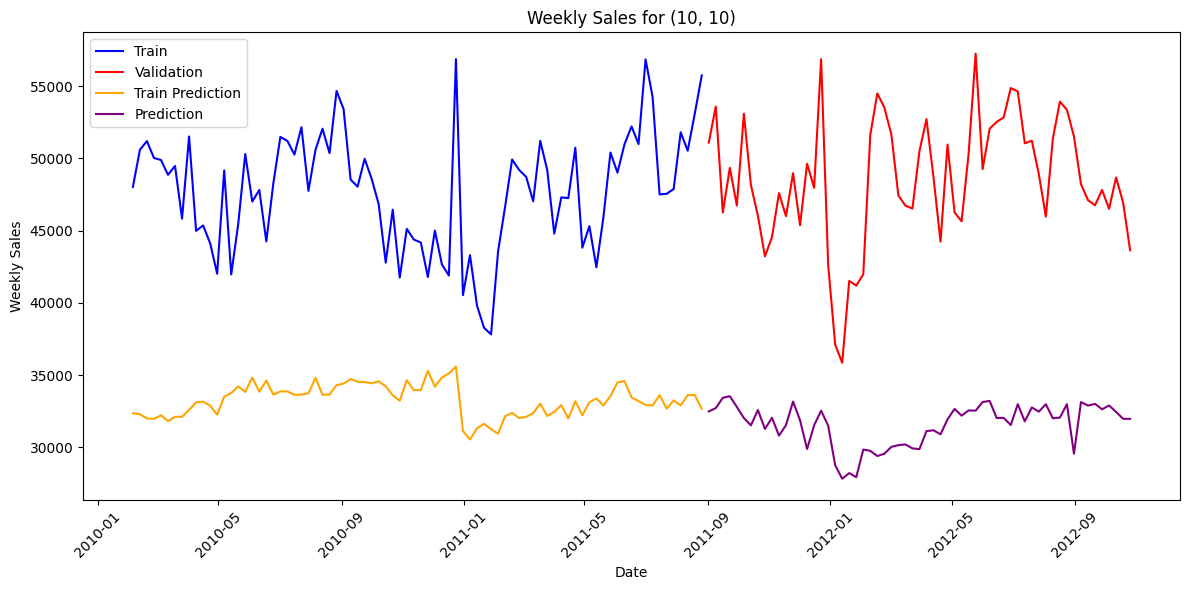

In [79]:
plot_store_dept(models[-1], 10, 10)

## Experiment 15

In [81]:
class Model15(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_AbsoluteError_Estimator_300_LowerLR",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:absoluteerror',
        'eval_metric': 'mae',
        'eta': 0.07,
      },
      'num_boost_round': 300,
    }

In [82]:
model15 = Model15(preprocessor_factory=preprocessor_factory1)
model15.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae', 'eta': 0.07}, 'num_boost_round': 300}
[0]	train-mae:12912.94772	train-wmae:12912.94824	test-mae:13249.48656	test-wmae:13249.48633
[1]	train-mae:12432.06154	train-wmae:12432.06152	test-mae:12768.47716	test-wmae:12768.47754
[2]	train-mae:11984.81018	train-wmae:11984.81055	test-mae:12320.20583	test-wmae:12320.20703
[3]	train-mae:11581.97075	train-wmae:11581.97168	test-mae:11913.90445	test-wmae:11913.90430
[4]	train-mae:11214.16462	train-wmae:11214.16504	test-mae:11544.28003	test-wmae:11544.28125
[5]	train-mae:10808.40967	train-wmae:10808.41016	test-mae:11140.58822	test-wmae:11140.58887
[6]	train-mae:10446.83545	train-wmae:10446.83496	test-mae:10784.47465	test-wmae:10784.47461
[7]	train-mae:10158.41698	train-wmae:10158.41602	test-mae:10493.72579	test-wmae:10493.72559
[8]	train-mae:9846.31352	train-wmae:9846.31250	test-mae:10191.50707	test-wmae:10191.50684
[9]	train-mae:9639.14425	train-wmae:9639.14453

Model Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae', 'eta': 0.07}, 'num_boost_round': 300}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 3478.8105230097053, 'mae_test': 3994.1150552844933, 'wmae_train': np.float64(3633.546736965458), 'wmae_test': np.float64(4246.602962894529)}
Model Data {'run_name': 'XGBoost_Obj_AbsoluteError_Estimator_300_LowerLR', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


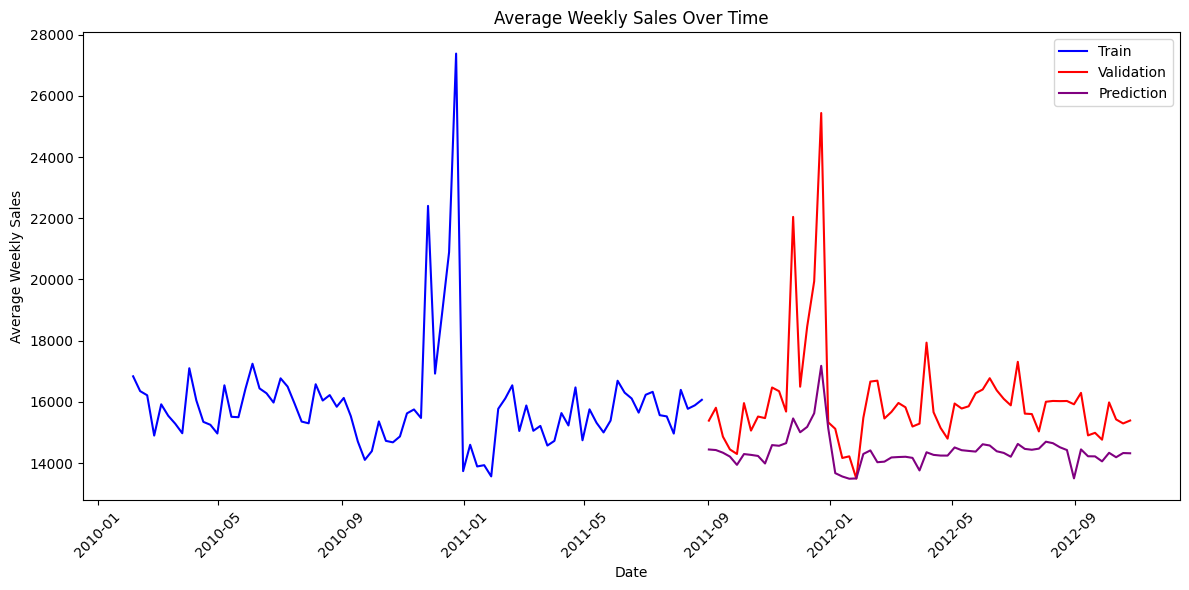

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [13:12:47] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/05 13:12:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_AbsoluteError_Estimator_300_LowerLR at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/b9881f9a1aba4088a854be6961c424be
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [83]:
log_experiment(model15)

## Experiment 16

In [86]:
class Model16(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_AbsoluteError_Estimator_300_LR_0.25",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:absoluteerror',
        'eval_metric': 'mae',
        'eta': 0.25,
      },
      'num_boost_round': 300,
    }

In [87]:
model16 = Model16(preprocessor_factory=preprocessor_factory1)
model16.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae', 'eta': 0.25}, 'num_boost_round': 300}
[0]	train-mae:11588.88872	train-wmae:11588.88965	test-mae:11925.86298	test-wmae:11925.86231
[1]	train-mae:10384.56428	train-wmae:10384.56445	test-mae:10707.67002	test-wmae:10707.67188
[2]	train-mae:9651.78125	train-wmae:9651.78125	test-mae:9971.71945	test-wmae:9971.71973
[3]	train-mae:8984.84915	train-wmae:8984.84961	test-mae:9319.84288	test-wmae:9319.84180
[4]	train-mae:8539.55719	train-wmae:8539.55664	test-mae:8879.16074	test-wmae:8879.16016
[5]	train-mae:8264.31183	train-wmae:8264.31250	test-mae:8617.17574	test-wmae:8617.17578
[6]	train-mae:7953.17758	train-wmae:7953.17822	test-mae:8330.61708	test-wmae:8330.61719
[7]	train-mae:7599.31034	train-wmae:7599.31055	test-mae:7978.84194	test-wmae:7978.84131
[8]	train-mae:7283.63191	train-wmae:7283.63281	test-mae:7653.77895	test-wmae:7653.77930
[9]	train-mae:7107.16881	train-wmae:7107.16846	test-mae:7495.45341	test-

Model Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae', 'eta': 0.25}, 'num_boost_round': 300}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 2587.0418436004147, 'mae_test': 3485.106857881862, 'wmae_train': np.float64(2694.6439603335293), 'wmae_test': np.float64(3686.791923130598)}
Model Data {'run_name': 'XGBoost_Obj_AbsoluteError_Estimator_300_LR_0.25', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


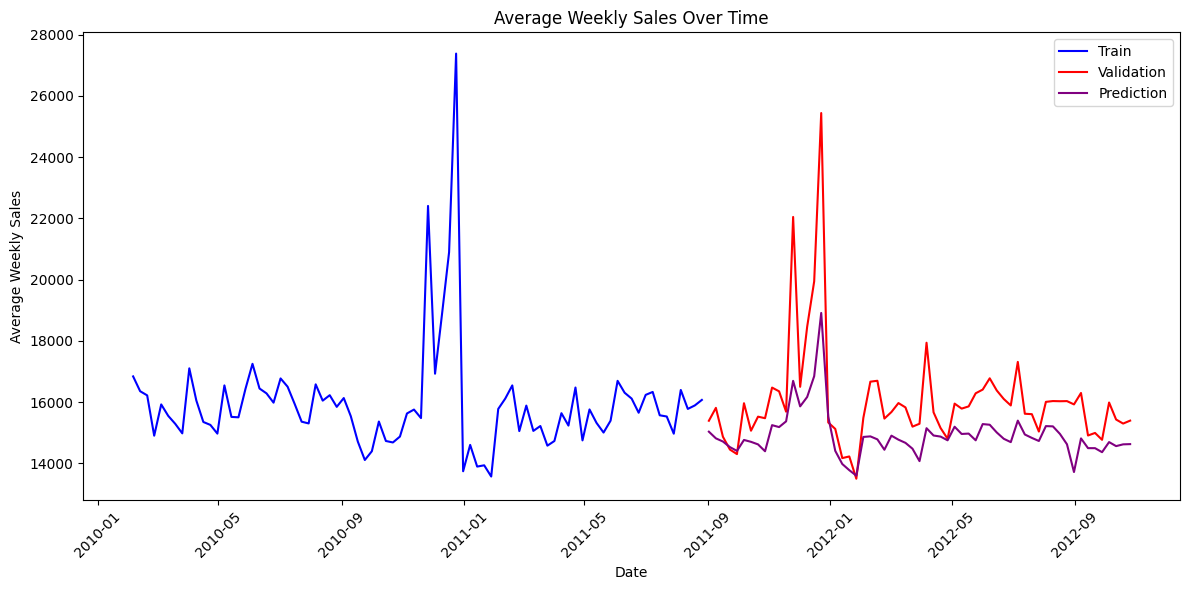

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [13:15:48] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/05 13:15:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_AbsoluteError_Estimator_300_LR_0.25 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/e3bb09c5e10444ccbd5c0e606e51fbda
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [88]:
log_experiment(model16)

## Experiment 17

In [89]:
class Model17(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_SquaredError_Estimator_300_LR_0.1",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'eta': 0.1
      },
      'num_boost_round': 300,
    }

In [90]:
model17 = Model17(preprocessor_factory=preprocessor_factory1)
model17.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'eta': 0.1}, 'num_boost_round': 300}
[0]	train-mae:14146.29116	train-wmae:14146.29102	test-mae:14500.05251	test-wmae:14500.05078
[1]	train-mae:13201.47687	train-wmae:13201.47754	test-mae:13543.19891	test-wmae:13543.19922
[2]	train-mae:12378.45165	train-wmae:12378.45117	test-mae:12712.06668	test-wmae:12712.06543
[3]	train-mae:11648.12892	train-wmae:11648.12891	test-mae:11976.70993	test-wmae:11976.70996
[4]	train-mae:11084.87620	train-wmae:11084.87598	test-mae:11405.55024	test-wmae:11405.54981
[5]	train-mae:10535.50197	train-wmae:10535.50098	test-mae:10859.64651	test-wmae:10859.64648
[6]	train-mae:10092.28077	train-wmae:10092.28027	test-mae:10414.18635	test-wmae:10414.18652
[7]	train-mae:9653.17625	train-wmae:9653.17773	test-mae:9972.51266	test-wmae:9972.51367
[8]	train-mae:9314.83727	train-wmae:9314.83594	test-mae:9630.30864	test-wmae:9630.30957
[9]	train-mae:9023.96698	train-wmae:9023.96680	test-ma

Model Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'eta': 0.1}, 'num_boost_round': 300}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 2826.7671634097796, 'mae_test': 3597.781223745917, 'wmae_train': np.float64(2869.917885768608), 'wmae_test': np.float64(3761.532148493818)}
Model Data {'run_name': 'XGBoost_Obj_SquaredError_Estimator_300_LR_0.1', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


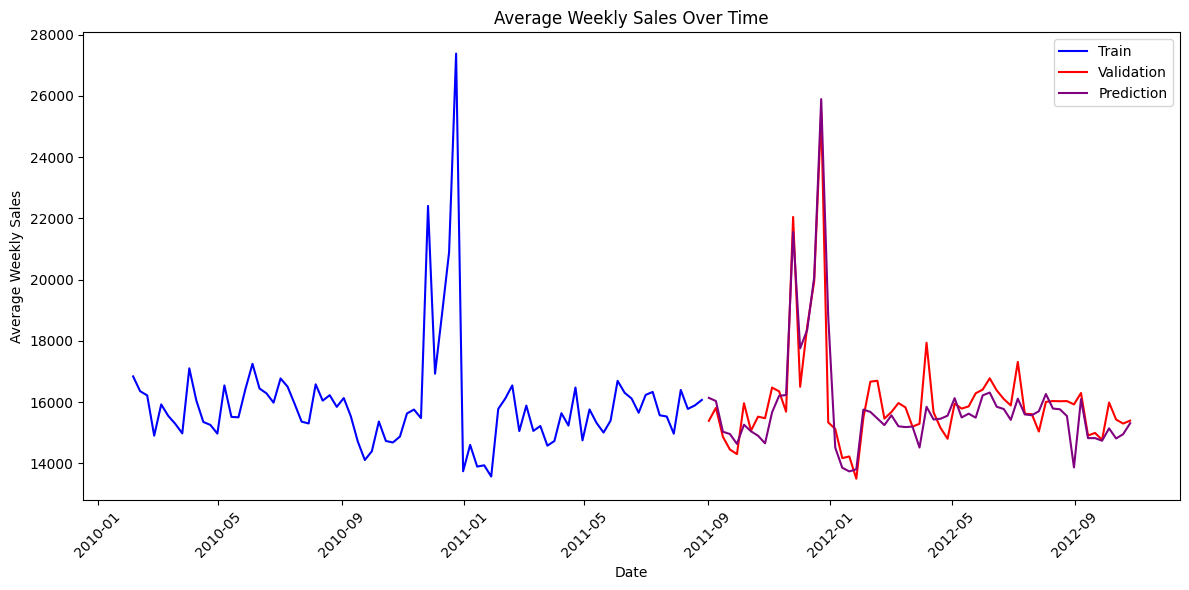

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [13:19:39] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/05 13:19:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_SquaredError_Estimator_300_LR_0.1 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/e583010bf4b44a59a91540a3c47ad393
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [91]:
log_experiment(model17)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


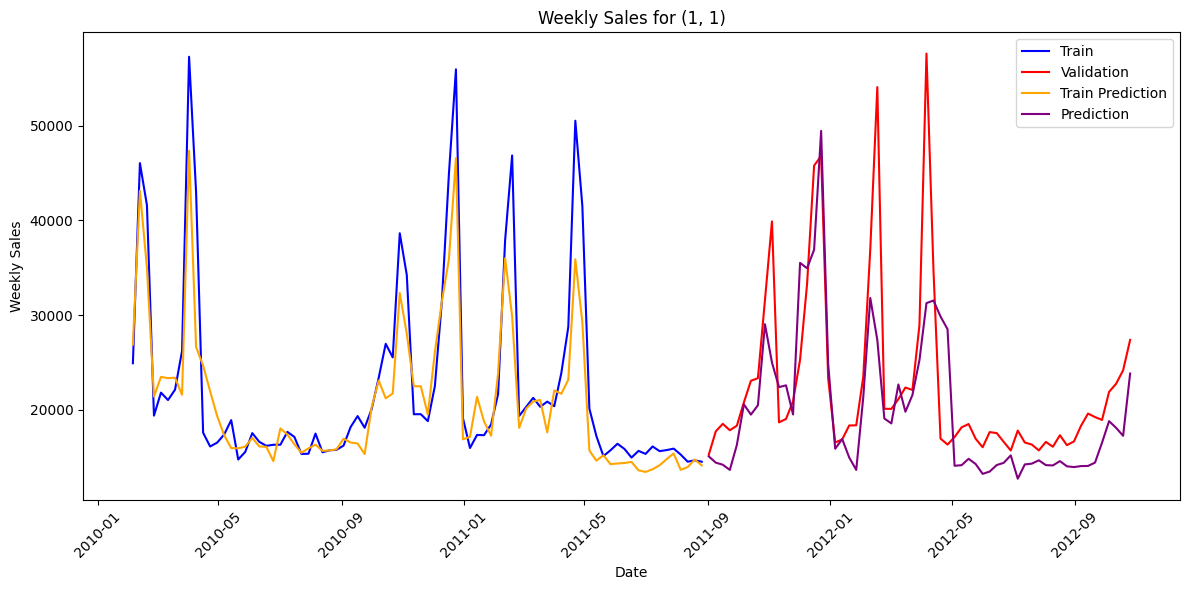

In [93]:
plot_store_dept(model17, 1, 1)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


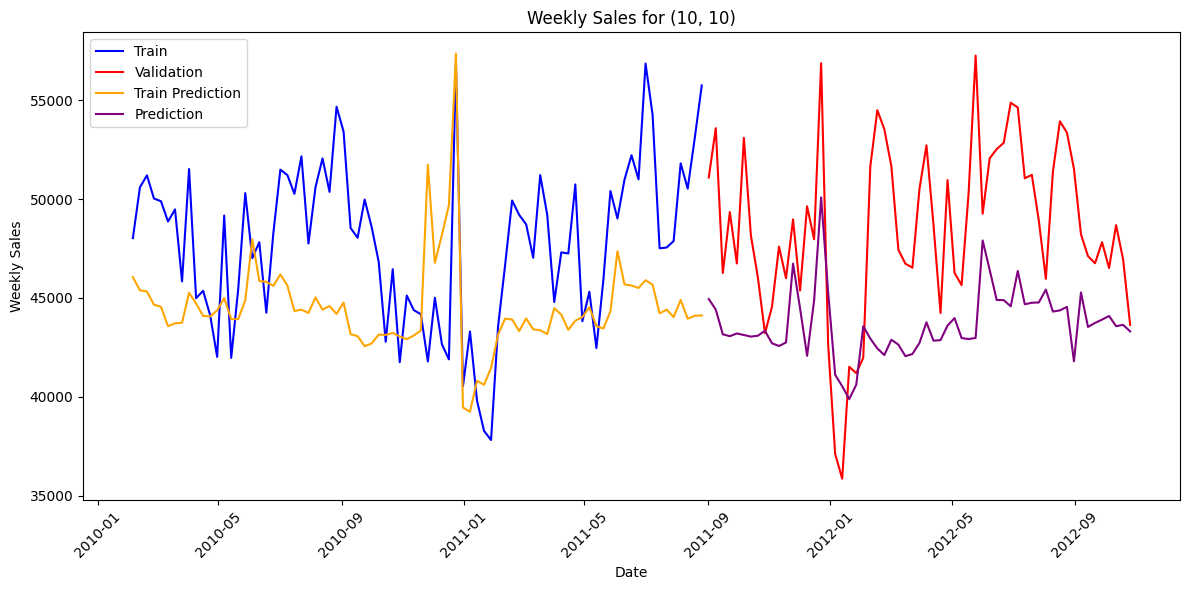

In [92]:
plot_store_dept(model17, 10, 10)

## Run this to save the notebook to DagsHub 👇

In [ ]:
from dagshub.notebook import save_notebook

save_notebook(repo="Cimbir/Store-Sales-Forecasting", path=".")